# Fast Holdout Evaluation (BRSET + MBRSET)

This notebook builds a **single 80/20 patient-level split per dataset** and reuses it for every embeddings file.
That guarantees a fair, like-for-like comparison across models and embeddings.

We evaluate:
- **Binary DR tasks**: `task_any_diab_retino`, `task_ref_macular`
- **3-class DR task**: `task_3class`

> Note: embeddings are already numeric, so we skip heavy preprocessing and focus on clean labels and consistent splits.

## Notebook map (run in order)

1) Setup + paths

2) Helper functions (split + dataset utilities)

3) Patient counts (sanity check)

4) Full sweep across all embeddings (LGBM + MLP)

5) Summary tables

6) Training dynamics helpers

7) Training dynamics for ALL embeddings (full training)

8) Detailed evaluation for ALL embeddings (reports + confusion matrices + ROC)


Notes:
- The 80/20 split is patient-level and reused across all embeddings.
- Training curves use **iterations/epochs**, not training samples.

## 1) Setup and configuration

Defines project paths, datasets, tasks, and model list.

In [ ]:
# CPU threading (run BEFORE importing numpy/pandas/sklearn for best effect)
import os
import multiprocessing

CPU_COUNT = multiprocessing.cpu_count()
THREAD_VARS = [
    "OMP_NUM_THREADS",
    "MKL_NUM_THREADS",
    "OPENBLAS_NUM_THREADS",
    "NUMEXPR_NUM_THREADS",
    "VECLIB_MAXIMUM_THREADS",
    "BLIS_NUM_THREADS",
    "LOKY_MAX_CPU_COUNT",
 ]

for v in THREAD_VARS:
    os.environ[v] = str(CPU_COUNT)

print(f"Configured thread env vars for {CPU_COUNT} CPU cores.")
print("Note: restart the kernel and run from the top for this to fully apply.")

In [1]:
from pathlib import Path
import importlib
import pandas as pd

import src.retina_evaluation as reval
from src.retina_benchmark import list_embeddings_csvs
from src.retina_embeddings_dataset import load_retina_embeddings_dataset

reval = importlib.reload(reval)

PROJECT_ROOT = Path.cwd()
VAL_FRAC = 0.2
RANDOM_SEED = 13
MODEL_NAMES = ["lgbm", "mlp"]

DATASETS = [
    {"name": "brset", "view": "all"},
    {"name": "mbrset", "view": "macula"},
]
BINARY_TASK_MAP = {
    "task_any_dr": "task_any_diab_retino",
    "task_referable": "task_ref_macular",
}
BINARY_TASKS = list(BINARY_TASK_MAP.keys())

## 2) Patient counts (sanity check)

Confirms patient counts and split sizes for BRSET/MBRSET.

In [5]:
# total patient count brset and mbrset

import pandas as pd

# Safety: define _paths_for_dataset if this cell is run before the helpers cell
if "_paths_for_dataset" not in globals():
    def _paths_for_dataset(dataset_name: str):
        embed_dir = PROJECT_ROOT / "data" / f"{dataset_name}_embeddings"
        labels_path = embed_dir / f"{dataset_name}_labels" / f"labels_{dataset_name}.csv"
        return embed_dir, labels_path

def _patient_col_from_labels(labels_df: pd.DataFrame) -> str:
    # Prefer canonical name, but MBRSET uses `patient`
    for cand in ("patient_id", "patient", "subject_id", "SubjectID", "PatientID"):
        if cand in labels_df.columns:
            return cand
    # Heuristic fallback
    lower_map = {c.lower(): c for c in labels_df.columns}
    for cand in ("patient", "patient_id", "patientid", "subject_id"):
        if cand in lower_map:
            return lower_map[cand]
    raise ValueError(f"Could not infer patient column from labels columns: {list(labels_df.columns)[:15]}...")

def _unique_patients_in_labels(dataset_name: str) -> int:
    _, labels_path = _paths_for_dataset(dataset_name)
    labels_df = pd.read_csv(labels_path)
    patient_col = _patient_col_from_labels(labels_df)
    return labels_df[patient_col].nunique()

def _unique_patients_in_used_df(dataset_name: str, view: str) -> int:
    embed_dir, labels_path = _paths_for_dataset(dataset_name)
    embedding_files = list_embeddings_csvs(embed_dir)
    if not embedding_files:
        raise FileNotFoundError(f"No embeddings CSVs found in {embed_dir}")
    ds = load_retina_embeddings_dataset(
        dataset=dataset_name,
        embeddings_csv_path=embedding_files[0],
        labels_csv_path=labels_path,
        view=view,
    )
    return ds.df["patient_id"].nunique()

for cfg in DATASETS:
    name, view = cfg["name"], cfg["view"]

    total_labels = _unique_patients_in_labels(name)
    total_used = _unique_patients_in_used_df(name, view)

    # confirm the split sizes add up (for the actually used dataframe)
    embed_dir, labels_path = _paths_for_dataset(name)
    emb0 = list_embeddings_csvs(embed_dir)[0]
    base_ds = load_retina_embeddings_dataset(
        dataset=name,
        embeddings_csv_path=emb0,
        labels_csv_path=labels_path,
        view=view,
    )
    split = reval.make_patient_split(
        df=base_ds.df,
        group_col="patient_id",
        label_col="task_any_dr",
        val_frac=VAL_FRAC,
        seed=RANDOM_SEED,
    )

    print(f"\n[{name.upper()}] view={view}")
    print(f"Unique patients in labels CSV: {total_labels}")
    print(f"Unique patients actually used (after view/merge/filters): {total_used}")
    print(
        "Split patients -> "
        f"train: {len(split.train_patient_ids)} | "
        f"val: {len(split.val_patient_ids)} | "
        f"total: {len(split.train_patient_ids) + len(split.val_patient_ids)}"
    )


[BRSET] view=all
Unique patients in labels CSV: 8524
Unique patients actually used (after view/merge/filters): 8524
Split patients -> train: 6819 | val: 1705 | total: 8524

[MBRSET] view=macula
Unique patients in labels CSV: 1291
Unique patients actually used (after view/merge/filters): 1291
Split patients -> train: 1032 | val: 259 | total: 1291


## Experiment flow

1. **Build a patient-level split per dataset** using `task_any_diab_retino` for stratification.
2. **Reuse the same split across every embeddings file** in that dataset.
3. **Train + evaluate** binary and 3-class DR tasks on the holdout split.

This makes comparisons across embeddings fair and fast.

In [3]:
def _paths_for_dataset(dataset_name: str):
    embed_dir = PROJECT_ROOT / "data" / f"{dataset_name}_embeddings"
    labels_path = embed_dir / f"{dataset_name}_labels" / f"labels_{dataset_name}.csv"
    return embed_dir, labels_path


def run_holdout_for_dataset(
    dataset_name: str,
    view: str,
    *,
    eval_level: str = "sample",
    rebalance: bool = True,
    pos_weight_multiplier: float = 1.0,
    class_weight_power: float = 1.0,
    tune_threshold: bool = False,
    tune_objective: str = "f1",
 ):
    embed_dir, labels_path = _paths_for_dataset(dataset_name)
    embedding_files = list_embeddings_csvs(embed_dir)
    print(f"[{dataset_name}] Found {len(embedding_files)} embedding files")
    print(
        f"[{dataset_name}] eval_level={eval_level} | rebalance={rebalance} | pos_weight_multiplier={pos_weight_multiplier} | "
        f"class_weight_power={class_weight_power} | tune_threshold={tune_threshold} ({tune_objective})"
    )

    base_ds = load_retina_embeddings_dataset(
        dataset=dataset_name,
        embeddings_csv_path=embedding_files[0],
        labels_csv_path=labels_path,
        view=view,
    )
    split = reval.make_patient_split(
        df=base_ds.df,
        group_col="patient_id",
        label_col="task_any_dr",
        val_frac=VAL_FRAC,
        seed=RANDOM_SEED,
    )
    print(f"[{dataset_name}] Train patients: {len(split.train_patient_ids)} | Val patients: {len(split.val_patient_ids)}")

    binary_results = []
    multiclass_results = []

    for emb_path in embedding_files:
        ds = load_retina_embeddings_dataset(
            dataset=dataset_name,
            embeddings_csv_path=emb_path,
            labels_csv_path=labels_path,
            view=view,
        )
        train_df, val_df = reval.apply_patient_split(ds.df, split, group_col="patient_id")

        for task in BINARY_TASKS:
            if task not in ds.df.columns:
                continue
            res = reval.evaluate_models_holdout(
                train_df=train_df,
                val_df=val_df,
                feature_cols=ds.feature_cols,
                label_col=task,
                model_names=MODEL_NAMES,
                task_type="binary",
                eval_level=eval_level,
                rebalance=rebalance,
                pos_weight_multiplier=pos_weight_multiplier,
                class_weight_power=class_weight_power,
                tune_threshold=tune_threshold,
                tune_objective=tune_objective,
                seed=RANDOM_SEED,
            )
            summary = res.summary.copy()
            summary.insert(0, "dataset", dataset_name)
            summary.insert(1, "embeddings", emb_path.stem)
            summary.insert(2, "task", BINARY_TASK_MAP.get(task, task))
            binary_results.append(summary)

        if "task_3class" in ds.df.columns:
            res = reval.evaluate_models_holdout(
                train_df=train_df,
                val_df=val_df,
                feature_cols=ds.feature_cols,
                label_col="task_3class",
                model_names=MODEL_NAMES,
                task_type="multiclass",
                eval_level=eval_level,
                rebalance=rebalance,
                pos_weight_multiplier=pos_weight_multiplier,
                class_weight_power=class_weight_power,
                seed=RANDOM_SEED,
            )
            summary = res.summary.copy()
            summary.insert(0, "dataset", dataset_name)
            summary.insert(1, "embeddings", emb_path.stem)
            summary.insert(2, "task", "task_3class")
            multiclass_results.append(summary)

    binary_summary = pd.concat(binary_results, ignore_index=True) if binary_results else pd.DataFrame()
    multiclass_summary = (
        pd.concat(multiclass_results, ignore_index=True) if multiclass_results else pd.DataFrame()
    )
    return binary_summary, multiclass_summary

## 3) Full sweep across all embeddings

Trains LGBM + MLP on all embeddings using the fixed 80/20 patient split.

In [6]:
# Run holdout sweep per dataset/view (patient-level decision metrics)
EVAL_LEVEL = "patient"  # "sample" or "patient"

# Use defaults if earlier config cells weren't run in this kernel session
REBALANCE_ = globals().get("REBALANCE", True)
POS_WEIGHT_MULTIPLIER_ = globals().get("POS_WEIGHT_MULTIPLIER", 1.0)
CLASS_WEIGHT_POWER_ = globals().get("CLASS_WEIGHT_POWER", 1.0)
TUNE_THRESHOLD_ = globals().get("TUNE_THRESHOLD", False)
TUNE_OBJECTIVE_ = globals().get("TUNE_OBJECTIVE", "f1")

all_binary = []
all_multiclass = []

for cfg in DATASETS:
    ds_name, view = cfg["name"], cfg["view"]
    bsum, msum = run_holdout_for_dataset(
        ds_name,
        view=view,
        eval_level=EVAL_LEVEL,
        rebalance=REBALANCE_,
        pos_weight_multiplier=POS_WEIGHT_MULTIPLIER_,
        class_weight_power=CLASS_WEIGHT_POWER_,
        tune_threshold=TUNE_THRESHOLD_,
        tune_objective=TUNE_OBJECTIVE_,
    )
    if not bsum.empty:
        all_binary.append(bsum)
    if not msum.empty:
        all_multiclass.append(msum)

binary_summary = pd.concat(all_binary, ignore_index=True) if all_binary else pd.DataFrame()
multiclass_summary = pd.concat(all_multiclass, ignore_index=True) if all_multiclass else pd.DataFrame()

binary_summary, multiclass_summary

NameError: name 'REBALANCE' is not defined

## 4) Summary tables

Shows aggregated metrics across all embeddings for binary and 3-class tasks.

In [10]:
print("Binary tasks (DR any/referable)")
binary_summary.sort_values(["dataset", "task", "roc_auc"], ascending=[True, True, False]) if not binary_summary.empty else binary_summary

Binary tasks (DR any/referable)


dataset                                  embeddings                  task  \
12   brset   Embeddings_brset_RETFound_dinov2_shanghai  task_any_diab_retino   
8    brset              Embeddings_brset_dinov3_vitb16  task_any_diab_retino   
9    brset              Embeddings_brset_dinov3_vitb16  task_any_diab_retino   
13   brset   Embeddings_brset_RETFound_dinov2_shanghai  task_any_diab_retino   
0    brset           Embeddings_brset_convnextv2_base_  task_any_diab_retino   
4    brset       Embeddings_brset_dinov3_convnext_base  task_any_diab_retino   
1    brset           Embeddings_brset_convnextv2_base_  task_any_diab_retino   
5    brset       Embeddings_brset_dinov3_convnext_base  task_any_diab_retino   
20   brset      Embeddings_brset_RETFound_mae_shanghai  task_any_diab_retino   
24   brset                  Embeddings_brset_vit_base_  task_any_diab_retino   
16   brset     Embeddings_brset_RETFound_mae_natureCFP  task_any_diab_retino   
17   brset     Embeddings_brset_RETFound_mae_natureCFP  task_any_diab_retino   
21   brset      Embeddings_brset_RETFound_mae_shanghai  task_any_diab_retino   
25   brset                  Embeddings_brset_vit_base_  task_any_diab_retino   
14   brset   Embeddings_brset_RETFound_dinov2_shanghai      task_ref_macular   
15   brset   Embeddings_brset_RETFound_dinov2_shanghai      task_ref_macular   
10   brset              Embeddings_brset_dinov3_vitb16      task_ref_macular   
11   brset              Embeddings_brset_dinov3_vitb16      task_ref_macular   
2    brset           Embeddings_brset_convnextv2_base_      task_ref_macular   
6    brset       Embeddings_brset_dinov3_convnext_base      task_ref_macular   
3    brset           Embeddings_brset_convnextv2_base_      task_ref_macular   
26   brset                  Embeddings_brset_vit_base_      task_ref_macular   
7    brset       Embeddings_brset_dinov3_convnext_base      task_ref_macular   
22   brset      Embeddings_brset_RETFound_mae_shanghai      task_ref_macular   
18   brset     Embeddings_brset_RETFound_mae_natureCFP      task_ref_macular   
19   brset     Embeddings_brset_RETFound_mae_natureCFP      task_ref_macular   
23   brset      Embeddings_brset_RETFound_mae_shanghai      task_ref_macular   
27   brset                  Embeddings_brset_vit_base_      task_ref_macular   
36  mbrset             Embeddings_mbrset_dinov3_vitb16  task_any_diab_retino   
28  mbrset           Embeddings_convnextv2_base_mbrset  task_any_diab_retino   
37  mbrset             Embeddings_mbrset_dinov3_vitb16  task_any_diab_retino   
29  mbrset           Embeddings_convnextv2_base_mbrset  task_any_diab_retino   
40  mbrset  Embeddings_mbrset_RETFound_dinov2_shanghai  task_any_diab_retino   
52  mbrset                  Embeddings_vit_base_mbrset  task_any_diab_retino   
41  mbrset  Embeddings_mbrset_RETFound_dinov2_shanghai  task_any_diab_retino   
32  mbrset      Embeddings_mbrset_dinov3_convnext_base  task_any_diab_retino   
53  mbrset                  Embeddings_vit_base_mbrset  task_any_diab_retino   
33  mbrset      Embeddings_mbrset_dinov3_convnext_base  task_any_diab_retino   
44  mbrset    Embeddings_mbrset_RETFound_mae_natureCFP  task_any_diab_retino   
45  mbrset    Embeddings_mbrset_RETFound_mae_natureCFP  task_any_diab_retino   
48  mbrset     Embeddings_mbrset_RETFound_mae_shanghai  task_any_diab_retino   
49  mbrset     Embeddings_mbrset_RETFound_mae_shanghai  task_any_diab_retino   
38  mbrset             Embeddings_mbrset_dinov3_vitb16      task_ref_macular   
42  mbrset  Embeddings_mbrset_RETFound_dinov2_shanghai      task_ref_macular   
30  mbrset           Embeddings_convnextv2_base_mbrset      task_ref_macular   
39  mbrset             Embeddings_mbrset_dinov3_vitb16      task_ref_macular   
34  mbrset      Embeddings_mbrset_dinov3_convnext_base      task_ref_macular   
43  mbrset  Embeddings_mbrset_RETFound_dinov2_shanghai      task_ref_macular   
31  mbrset           Embeddings_convnextv2_base_mbrset      task_ref_macular   
54 

In [11]:
print("3-class DR task")
multiclass_summary.sort_values(["dataset", "roc_auc_ovr"], ascending=[True, False]) if not multiclass_summary.empty else multiclass_summary

3-class DR task


dataset                                  embeddings         task model  \
6    brset   Embeddings_brset_RETFound_dinov2_shanghai  task_3class  lgbm   
4    brset              Embeddings_brset_dinov3_vitb16  task_3class  lgbm   
5    brset              Embeddings_brset_dinov3_vitb16  task_3class   mlp   
7    brset   Embeddings_brset_RETFound_dinov2_shanghai  task_3class   mlp   
0    brset           Embeddings_brset_convnextv2_base_  task_3class  lgbm   
2    brset       Embeddings_brset_dinov3_convnext_base  task_3class  lgbm   
3    brset       Embeddings_brset_dinov3_convnext_base  task_3class   mlp   
1    brset           Embeddings_brset_convnextv2_base_  task_3class   mlp   
10   brset      Embeddings_brset_RETFound_mae_shanghai  task_3class  lgbm   
12   brset                  Embeddings_brset_vit_base_  task_3class  lgbm   
8    brset     Embeddings_brset_RETFound_mae_natureCFP  task_3class  lgbm   
13   brset                  Embeddings_brset_vit_base_  task_3class   mlp   
11   brset      Embeddings_brset_RETFound_mae_shanghai  task_3class   mlp   
9    brset     Embeddings_brset_RETFound_mae_natureCFP  task_3class   mlp   
18  mbrset             Embeddings_mbrset_dinov3_vitb16  task_3class  lgbm   
20  mbrset  Embeddings_mbrset_RETFound_dinov2_shanghai  task_3class  lgbm   
14  mbrset           Embeddings_convnextv2_base_mbrset  task_3class  lgbm   
16  mbrset      Embeddings_mbrset_dinov3_convnext_base  task_3class  lgbm   
17  mbrset      Embeddings_mbrset_dinov3_convnext_base  task_3class   mlp   
21  mbrset  Embeddings_mbrset_RETFound_dinov2_shanghai  task_3class   mlp   
26  mbrset                  Embeddings_vit_base_mbrset  task_3class  lgbm   
19  mbrset             Embeddings_mbrset_dinov3_vitb16  task_3class   mlp   
27  mbrset                  Embeddings_vit_base_mbrset  task_3class   mlp   
22  mbrset    Embeddings_mbrset_RETFound_mae_natureCFP  task_3class  lgbm   
15  mbrset           Embeddings_convnextv2_base_mbrset  task_3class   mlp   
24  mbrset     Embeddings_mbrset_RETFound_mae_shanghai  task_3class  lgbm   
23  mbrset    Embeddings_mbrset_RETFound_mae_natureCFP  task_3class   mlp   
25  mbrset     Embeddings_mbrset_RETFound_mae_shanghai  task_3class   mlp   

         n  accuracy  balanced_accuracy  f1_macro  roc_auc_ovr  eval_level  
6   1705.0  0.960117           0.627111  0.693689     0.952796         1.0  
4   1705.0  0.964809           0.685435  0.731377     0.952632         1.0  
5   1705.0  0.912023           0.757019  0.644081     0.936348         1.0  
7   1705.0  0.899707           0.745062  0.626329     0.934895         1.0  
0   1705.0  0.960117           0.637303  0.693710     0.934445         1.0  
2   1705.0  0.954839           0.570947  0.630597     0.927879         1.0  
3   1705.0  0.916129           0.706939  0.626909     0.919377         1.0  
1   1705.0  0.920235           0.746990  0.628822     0.914314         1.0  
10  1705.0  0.944282           0.507981  0.555359     0.910667         1.0  
12  1705.0  0.951906           0.554498  0.626714     0.900794         1.0  
8   1705.0  0.946041           0.505998  0.563402     0.897608         1.0  
13  1705.0  0.899707           0.695941  0.587568     0.897090         1.0  
11  1705.0  0.892082           0.649281  0.587904     0.887591         1.0  
9   1705.0  0.866862           0.642984  0.541670     0.872725         1.0  
18   258.0  0.883721           0.673603  0.720431     0.928990         1.0  
20   258.0  0.875969           0.684256  0.746987     0.899105         1.0  
14   258.0  0.875969           0.677319  0.711099     0.898611         1.0  
16   258.0  0.872093           0.661836  0.695857     0.887432         1.0  
17   258.0  0.744186           0.700452  0.644225     0.875979         1.0  
21   258.0  0.860465           0.730150  0.711102     0.871493         1.0  
26   258.0  0.837209           0.474885  0.516845     0.866062         1.0  
19   258.0  0.767442           0.673851  0.606751     0.861775         1.0 

In [9]:
# Train vs validation gap across embeddings (F1-focused)

import numpy as np
import pandas as pd

# Controls (set to None to run all; can be slow)
MAX_EMBEDDINGS_PER_DATASET = 2  # limit for speed
ONLY_MODELS = None  # None => uses MODEL_NAMES
INCLUDE_TASKS = ["task_any_dr"]  # focus for speed
TUNE_THRESHOLD_FOR_GAP = False
TUNE_OBJECTIVE_FOR_GAP = "recall"  # "f1" | "balanced_accuracy" | "recall"

# Fall back to defaults if the sweep-knobs cell wasn't executed yet
rebalance = bool(globals().get("REBALANCE", True))
pos_weight_multiplier = float(globals().get("POS_WEIGHT_MULTIPLIER", 1.0))
class_weight_power = float(globals().get("CLASS_WEIGHT_POWER", 1.0))
model_names = list(globals().get("MODEL_NAMES", ["lgbm", "mlp"])) if ONLY_MODELS is None else list(ONLY_MODELS)

rows: list[dict] = []

for cfg in DATASETS:
    dataset_name = cfg["name"]
    view = cfg["view"]
    embed_dir, labels_path = _paths_for_dataset(dataset_name)
    embedding_files = list_embeddings_csvs(embed_dir)
    if not embedding_files:
        continue
    if MAX_EMBEDDINGS_PER_DATASET is not None:
        embedding_files = embedding_files[: int(MAX_EMBEDDINGS_PER_DATASET)]

    # One split reused across embeddings
    base_ds = load_retina_embeddings_dataset(
        dataset=dataset_name,
        embeddings_csv_path=embedding_files[0],
        labels_csv_path=labels_path,
        view=view,
    )
    split = reval.make_patient_split(
        df=base_ds.df,
        group_col="patient_id",
        label_col="task_any_dr",
        val_frac=VAL_FRAC,
        seed=RANDOM_SEED,
    )

    for emb_idx, emb_path in enumerate(embedding_files):
        print(f"[{dataset_name}] ({emb_idx+1}/{len(embedding_files)}) {emb_path.name}")
        ds = load_retina_embeddings_dataset(
            dataset=dataset_name,
            embeddings_csv_path=emb_path,
            labels_csv_path=labels_path,
            view=view,
        )
        train_df, val_df = reval.apply_patient_split(ds.df, split, group_col="patient_id")

        for task in INCLUDE_TASKS:
            if task not in ds.df.columns:
                continue
            task_type = "binary" if task in BINARY_TASKS else "multiclass"
            display_task = BINARY_TASK_MAP.get(task, task)

            for model_name in model_names:
                model = reval.train_holdout_model(
                    train_df=train_df,
                    feature_cols=ds.feature_cols,
                    label_col=task,
                    model_name=model_name,
                    seed=RANDOM_SEED,
                    task_type=task_type,
                    rebalance=rebalance,
                    pos_weight_multiplier=pos_weight_multiplier,
                    class_weight_power=class_weight_power,
                )

                # Evaluate on validation first (optionally tune threshold on validation only)
                val_report = reval.evaluate_holdout_classification(
                    model=model,
                    val_df=val_df,
                    feature_cols=ds.feature_cols,
                    label_col=task,
                    task_type=task_type,
                    tune_threshold=(TUNE_THRESHOLD_FOR_GAP and task_type == "binary"),
                    tune_objective=TUNE_OBJECTIVE_FOR_GAP,
                )

                # Use the same probability threshold for train evaluation (keeps comparison fair).
                threshold = float(val_report.metrics.get("proba_threshold", 0.5))
                train_report = reval.evaluate_holdout_classification(
                    model=model,
                    val_df=train_df,
                    feature_cols=ds.feature_cols,
                    label_col=task,
                    task_type=task_type,
                    proba_threshold=threshold,
                    tune_threshold=False,
                )

                if task_type == "binary":
                    train_metric = float(train_report.metrics.get("f1", np.nan))
                    val_metric = float(val_report.metrics.get("f1", np.nan))
                    metric_name = "f1"
                else:
                    train_metric = float(train_report.metrics.get("f1_macro", np.nan))
                    val_metric = float(val_report.metrics.get("f1_macro", np.nan))
                    metric_name = "f1_macro"

                rows.append(
                    {
                        "dataset": dataset_name,
                        "embeddings": emb_path.stem,
                        "task": display_task,
                        "task_type": task_type,
                        "model": model_name,
                        "metric": metric_name,
                        "train": train_metric,
                        "val": val_metric,
                        "gap": train_metric - val_metric,
                        "val_threshold": threshold if task_type == "binary" else np.nan,
                        "n_train": int(train_report.metrics.get("n", np.nan)),
                        "n_val": int(val_report.metrics.get("n", np.nan)),
                    }
                )

gap_df = pd.DataFrame(rows)
print(f"Computed gaps for {len(gap_df)} rows")
gap_df.sort_values(["dataset", "task", "model", "gap"], ascending=[True, True, True, False]).head(25) if not gap_df.empty else gap_df

[brset] (1/2) Embeddings_brset_convnextv2_base_.csv
[brset] (2/2) Embeddings_brset_dinov3_convnext_base.csv
[mbrset] (1/2) Embeddings_convnextv2_base_mbrset.csv
[mbrset] (2/2) Embeddings_mbrset_dinov3_convnext_base.csv
Computed gaps for 8 rows


dataset                              embeddings                  task  \
2   brset   Embeddings_brset_dinov3_convnext_base  task_any_diab_retino   
0   brset       Embeddings_brset_convnextv2_base_  task_any_diab_retino   
1   brset       Embeddings_brset_convnextv2_base_  task_any_diab_retino   
3   brset   Embeddings_brset_dinov3_convnext_base  task_any_diab_retino   
6  mbrset  Embeddings_mbrset_dinov3_convnext_base  task_any_diab_retino   
4  mbrset       Embeddings_convnextv2_base_mbrset  task_any_diab_retino   
5  mbrset       Embeddings_convnextv2_base_mbrset  task_any_diab_retino   
7  mbrset  Embeddings_mbrset_dinov3_convnext_base  task_any_diab_retino   

  task_type model metric     train       val       gap  val_threshold  \
2    binary  lgbm     f1  0.961995  0.551929  0.410066            0.5   
0    binary  lgbm     f1  0.969303  0.568915  0.400388            0.5   
1    binary   mlp     f1  0.677980  0.500000  0.177980            0.5   
3    binary   mlp     f1  0.524733  0.427211  0.097522            0.5   
6    binary  lgbm     f1  0.952381  0.476190  0.476190            0.5   
4    binary  lgbm     f1  0.942826  0.579186  0.363641            0.5   
5    binary   mlp     f1  0.970748  0.553571  0.417176            0.5   
7    binary   mlp     f1  0.835317  0.527881  0.307436            0.5   

   n_train  n_val  
2    13015   3251  
0    13015   3251  
1    13015   3251  
3    13015   3251  
6     2064    518  
4     2064    518  
5     2064    518  
7     2064    518

## Detailed evaluation (LGBM + MLP)

The next section trains **LightGBM** and **MLP** on a single embeddings file per dataset
and then computes:
- Classification report
- Confusion matrix (plotted)
- ROC curve (binary tasks only)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

plt.style.use("seaborn-v0_8-whitegrid")

def _plot_confusion_matrix(cm, title: str):
    cm = np.asarray(cm)
    fig, ax = plt.subplots(figsize=(5.2, 4.6))
    im = ax.imshow(cm, cmap="viridis", interpolation="nearest")
    ax.set_title(title, fontsize=11, pad=12)
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("True", fontsize=10)
    ax.set_xticks(range(cm.shape[1]))
    ax.set_yticks(range(cm.shape[0]))
    ax.tick_params(axis="both", labelsize=9)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label("Count", fontsize=9)

    thresh = cm.max() / 2.0 if cm.size else 0
    for (i, j), val in np.ndenumerate(cm):
        ax.text(
            j,
            i,
            f"{val}",
            ha="center",
            va="center",
            color="white" if val > thresh else "black",
            fontsize=10,
            fontweight="bold",
        )
    plt.tight_layout()
    plt.show()


def _plot_roc_curve(roc_data, title: str):
    if roc_data is None:
        print("ROC curve not available for this task.")
        return
    fpr, tpr, _ = roc_data
    fig, ax = plt.subplots(figsize=(5.2, 4.6))

    points = np.array([fpr, tpr]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = Normalize(vmin=0.0, vmax=1.0)
    lc = LineCollection(segments, cmap="plasma", norm=norm)
    lc.set_array(fpr)
    lc.set_linewidth(2.6)
    ax.add_collection(lc)

    ax.plot([0, 1], [0, 1], linestyle="--", color="#666", linewidth=1.2, label="Chance")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=11, pad=12)
    ax.set_xlabel("False Positive Rate", fontsize=10)
    ax.set_ylabel("True Positive Rate", fontsize=10)
    ax.tick_params(axis="both", labelsize=9)
    ax.legend(loc="lower right", fontsize=9)
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("FPR (color gradient)", fontsize=9)
    cbar.ax.tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()

## Checking training and validation plots

## 5) Training dynamics helpers

Creates train vs validation curves over **iterations/epochs** (not training samples).

In [8]:
# Training dynamics plots (iterations / epochs)

# These plots answer: "does validation get worse as training continues?"
# - LightGBM: x-axis is iterations (trees).
# - MLP: x-axis is epochs (full passes through the training data).
#
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re


def _safe_plot_name(text: str) -> str:
    slug = re.sub(r"[^a-zA-Z0-9._-]+", "_", text).strip("_")
    return slug[:180] if slug else "plot"


def plot_training_dynamics(
    dataset_name: str,
    view: str,
    task: str,
    model_name: str,
    *,
    embedding_index: int = 0,
    early_stopping_rounds: int = 100,
    full_train: bool = True,
    full_n_estimators: int | None = None,
    mlp_max_epochs: int | None = None,
    mlp_track_validation: bool = True,
    show_plots: bool = True,
    save_dir: Path | None = None,
 ):
    embed_dir, labels_path = _paths_for_dataset(dataset_name)
    embedding_files = list_embeddings_csvs(embed_dir)
    if not embedding_files:
        raise FileNotFoundError(f"No embeddings found under {embed_dir}")
    emb_path = embedding_files[embedding_index]

    ds = load_retina_embeddings_dataset(
        dataset=dataset_name,
        embeddings_csv_path=emb_path,
        labels_csv_path=labels_path,
        view=view,
    )
    if task not in ds.df.columns:
        print(f"Task {task} not found in dataset {dataset_name}")
        return

    # Patient split for the validation curve (matches evaluation protocol)
    split = reval.make_patient_split(
        df=ds.df,
        group_col="patient_id",
        label_col="task_any_dr",
        val_frac=VAL_FRAC,
        seed=RANDOM_SEED,
    )
    train_df, val_df = reval.apply_patient_split(ds.df, split, group_col="patient_id")

    # Drop unlabeled rows for this task
    train_work = train_df.dropna(subset=[task]).copy()
    val_work = val_df.dropna(subset=[task]).copy()
    if train_work.empty or val_work.empty:
        print(f"Not enough labeled rows for {dataset_name}/{task}")
        return

    X_train = train_work.loc[:, ds.feature_cols].astype(np.float32)
    y_train = train_work[task].astype(int).to_numpy()
    X_val = val_work.loc[:, ds.feature_cols].astype(np.float32)
    y_val = val_work[task].astype(int).to_numpy()

    task_type = "binary" if task in BINARY_TASKS else "multiclass"
    display_task = BINARY_TASK_MAP.get(task, task)
    model_key = model_name.lower()

    print(f"\n[{dataset_name}] {display_task} | {model_name} | embeddings={emb_path.name}")
    print(f"Train rows: {len(X_train)} | Val rows: {len(X_val)}")
    print(f"Train patients: {train_work['patient_id'].nunique()} | Val patients: {val_work['patient_id'].nunique()}")

    if save_dir is not None:
        save_dir.mkdir(parents=True, exist_ok=True)
        plot_prefix = _safe_plot_name(f"{dataset_name}__{emb_path.stem}__{display_task}__{model_name}")
    else:
        plot_prefix = None

    if model_key in {"lgbm", "lightgbm"}:
        # NOTE: This uses the patient-level validation set as eval_set to produce a true
        # train-vs-validation curve over iterations. Use it for diagnostics, not tuning.
        from lightgbm import early_stopping, log_evaluation

        model = reval._make_model("lgbm", random_state=RANDOM_SEED)
        if full_n_estimators is not None:
            try:
                model.set_params(n_estimators=int(full_n_estimators))
            except Exception:
                pass
        eval_metric = "binary_logloss" if task_type == "binary" else "multi_logloss"
        try:
            model.set_params(eval_metric=eval_metric)
        except Exception:
            pass

        callbacks = [log_evaluation(period=0)]
        if not full_train:
            callbacks.insert(0, early_stopping(stopping_rounds=int(early_stopping_rounds), verbose=False))

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_names=["train", "val"],
            callbacks=callbacks,
        )

        res = getattr(model, "evals_result_", None)
        if not res:
            print("LightGBM did not expose evals_result_; cannot plot.")
            return

        train_series = res.get("train", {}).get(eval_metric, [])
        val_series = res.get("val", {}).get(eval_metric, [])
        iters = np.arange(1, 1 + max(len(train_series), len(val_series)))

        fig, ax = plt.subplots(figsize=(6.2, 4.3))
        if train_series:
            ax.plot(iters[: len(train_series)], train_series, label="Train loss", linewidth=2.4)
        if val_series:
            ax.plot(iters[: len(val_series)], val_series, label="Validation loss", linewidth=2.4)

        best_it = getattr(model, "best_iteration_", None)
        if not full_train and best_it is not None and best_it > 0:
            ax.axvline(best_it, color="#666", linestyle="--", linewidth=1.2, label=f"Best iter={best_it}")

        ax.set_title(f"{dataset_name} - {display_task} - LGBM training dynamics", fontsize=11, pad=10)
        ax.set_xlabel("Iterations", fontsize=10)
        ax.set_ylabel("Loss (lower is better)", fontsize=10)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.25)
        plt.tight_layout()
        if plot_prefix:
            out_path = save_dir / f"{plot_prefix}__train_val.png"
            fig.savefig(out_path, dpi=160, bbox_inches="tight")
        if show_plots:
            plt.show()
        else:
            plt.close(fig)

        report = reval.evaluate_holdout_classification(
            model=model,
            val_df=val_work,
            feature_cols=ds.feature_cols,
            label_col=task,
            task_type=task_type,
        )
        print("Validation metrics:", report.metrics)
        return

    if model_key in {"mlp", "mlp_sklearn"}:
        from sklearn.metrics import log_loss
        from sklearn.neural_network import MLPClassifier
        from sklearn.pipeline import Pipeline
        from sklearn.preprocessing import StandardScaler

        base_model = reval._make_model("mlp", random_state=RANDOM_SEED)
        scaler = base_model.named_steps.get("scaler") if hasattr(base_model, "named_steps") else StandardScaler()
        clf_base = base_model.named_steps.get("clf") if hasattr(base_model, "named_steps") else base_model
        max_epochs = int(mlp_max_epochs or getattr(clf_base, "max_iter", 200))

        if mlp_track_validation:
            X_train_s = scaler.fit_transform(X_train)
            X_val_s = scaler.transform(X_val)
            params = clf_base.get_params()
            params.update({"warm_start": True, "max_iter": 1, "early_stopping": False})
            loop_clf = MLPClassifier(**params)

            train_loss = []
            val_loss = []
            labels = np.unique(np.concatenate([y_train, y_val]))
            for _ in range(max_epochs):
                loop_clf.fit(X_train_s, y_train)
                train_loss.append(float(loop_clf.loss_))
                proba = loop_clf.predict_proba(X_val_s)
                val_loss.append(float(log_loss(y_val, proba, labels=labels)))

            epochs = np.arange(1, len(train_loss) + 1)
            fig, ax = plt.subplots(figsize=(6.2, 4.3))
            ax.plot(epochs, train_loss, label="Train loss", linewidth=2.4)
            ax.plot(epochs, val_loss, label="Validation loss", linewidth=2.4)
            ax.set_xlabel("Epochs", fontsize=10)
            ax.set_ylabel("Loss (lower is better)", fontsize=10)
            ax.set_title(f"{dataset_name} - {display_task} - MLP training dynamics", fontsize=11, pad=10)
            ax.grid(True, alpha=0.25)
            ax.legend(fontsize=9)
            plt.tight_layout()
            if plot_prefix:
                out_path = save_dir / f"{plot_prefix}__train_val.png"
                fig.savefig(out_path, dpi=160, bbox_inches="tight")
            if show_plots:
                plt.show()
            else:
                plt.close(fig)

            model = Pipeline(steps=[("scaler", scaler), ("clf", loop_clf)])
        else:
            model = reval._make_model("mlp", random_state=RANDOM_SEED)
            try:
                model.set_params(clf__max_iter=max_epochs, clf__early_stopping=False)
            except Exception:
                pass
            model.fit(X_train, y_train)
            clf = model.named_steps.get("clf") if hasattr(model, "named_steps") else model
            loss_curve = list(getattr(clf, "loss_curve_", []))
            if loss_curve:
                epochs = np.arange(1, len(loss_curve) + 1)
                fig, ax = plt.subplots(figsize=(6.2, 4.3))
                ax.plot(epochs, loss_curve, label="Train loss", linewidth=2.4)
                ax.set_xlabel("Epochs", fontsize=10)
                ax.set_ylabel("Loss (lower is better)", fontsize=10)
                ax.set_title(f"{dataset_name} - {display_task} - MLP training loss", fontsize=11, pad=10)
                ax.grid(True, alpha=0.25)
                ax.legend(fontsize=9)
                plt.tight_layout()
                if plot_prefix:
                    out_path = save_dir / f"{plot_prefix}__train_loss.png"
                    fig.savefig(out_path, dpi=160, bbox_inches="tight")
                if show_plots:
                    plt.show()
                else:
                    plt.close(fig)
            else:
                print("MLP did not expose loss_curve_; cannot plot epochs.")

        report = reval.evaluate_holdout_classification(
            model=model,
            val_df=val_work,
            feature_cols=ds.feature_cols,
            label_col=task,
            task_type=task_type,
        )
        print("Validation metrics:", report.metrics)
        return

    raise ValueError(f"Unsupported model_name: {model_name}")

## 6) Training dynamics for ALL embeddings (full training)

Generates train vs validation curves for every embedding, model, and task.
This can take a long time and produce many plots. Use `SHOW_PLOTS = False` to save only.

[brset] view=all | Train patients: 6819 | Val patients: 1705
[LightGBM] [Info] Number of positive: 841, number of negative: 12167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 13008, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064653 -> initscore=-2.671891
[LightGBM] [Info] Start training from score -2.671891


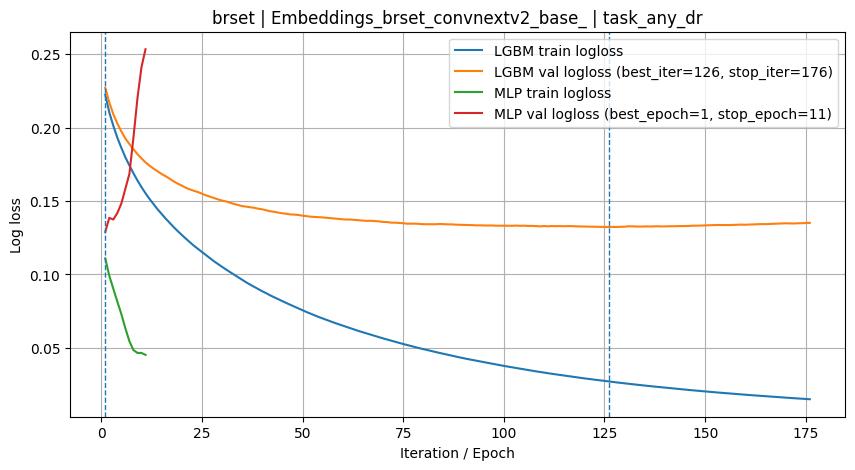

[LightGBM] [Info] Number of positive: 751, number of negative: 12257
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 13008, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.057734 -> initscore=-2.792447
[LightGBM] [Info] Start training from score -2.792447


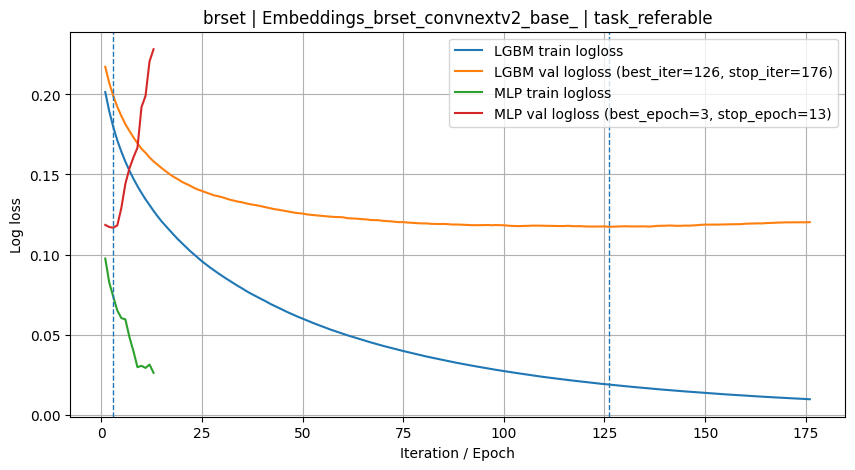

[LightGBM] [Info] Number of positive: 841, number of negative: 12167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 13008, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064653 -> initscore=-2.671891
[LightGBM] [Info] Start training from score -2.671891


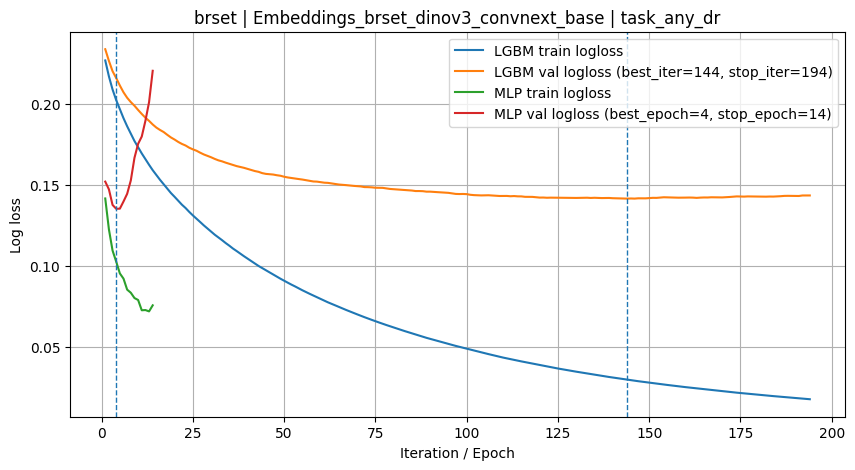

[LightGBM] [Info] Number of positive: 751, number of negative: 12257
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 13008, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.057734 -> initscore=-2.792447
[LightGBM] [Info] Start training from score -2.792447


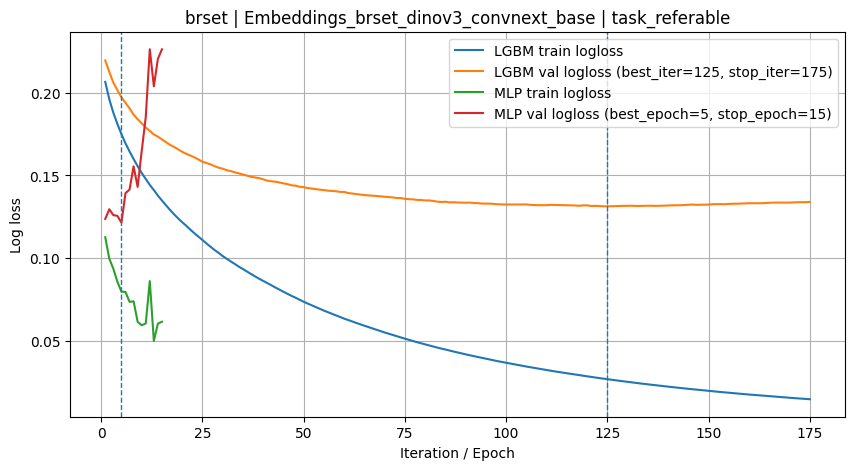

[LightGBM] [Info] Number of positive: 841, number of negative: 12167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 13008, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064653 -> initscore=-2.671891
[LightGBM] [Info] Start training from score -2.671891


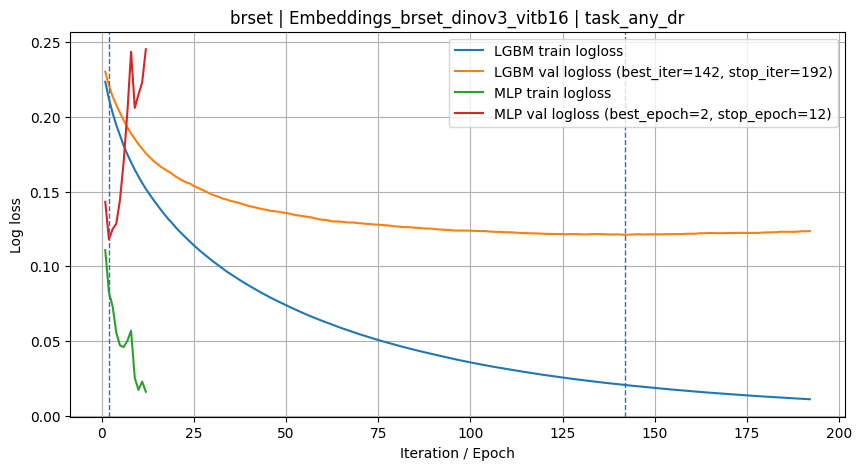

[LightGBM] [Info] Number of positive: 751, number of negative: 12257
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 13008, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.057734 -> initscore=-2.792447
[LightGBM] [Info] Start training from score -2.792447


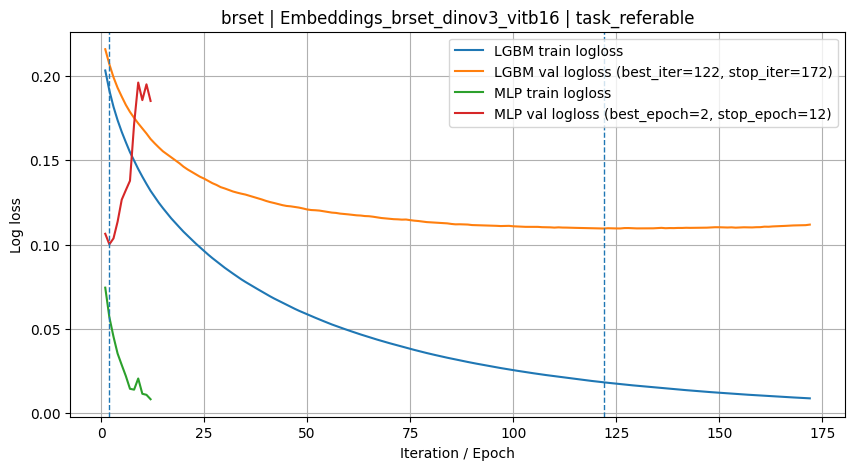

[LightGBM] [Info] Number of positive: 841, number of negative: 12167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 13008, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064653 -> initscore=-2.671891
[LightGBM] [Info] Start training from score -2.671891


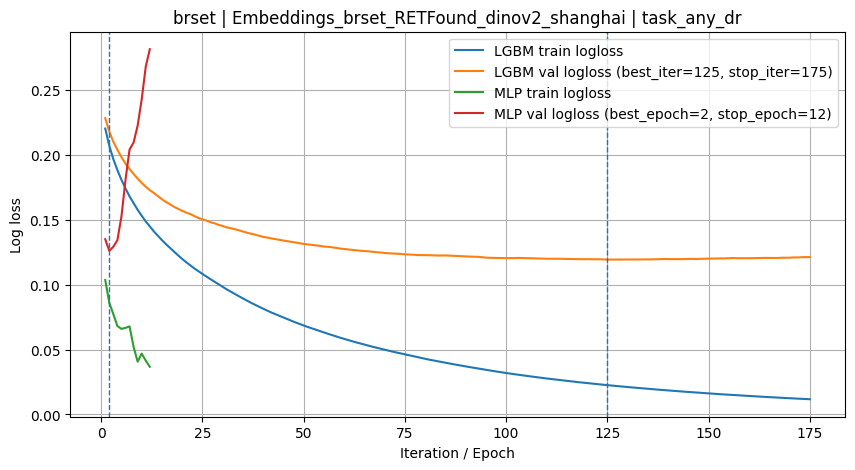

[LightGBM] [Info] Number of positive: 751, number of negative: 12257
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 13008, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.057734 -> initscore=-2.792447
[LightGBM] [Info] Start training from score -2.792447


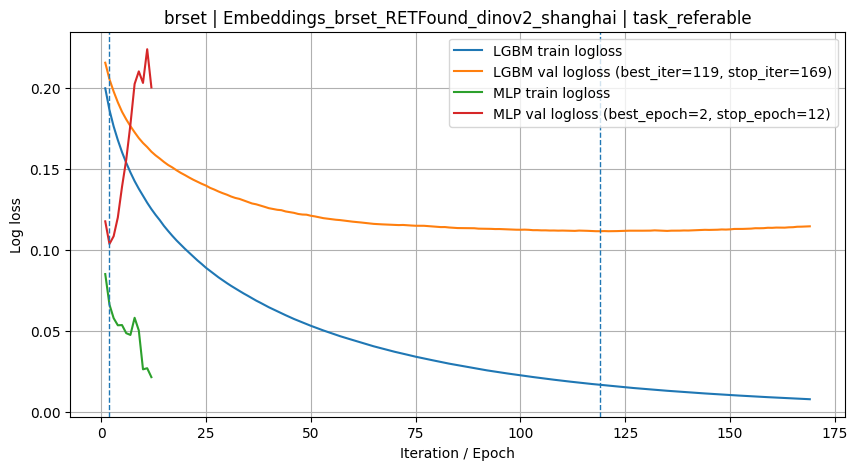

[LightGBM] [Info] Number of positive: 841, number of negative: 12167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 13008, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064653 -> initscore=-2.671891
[LightGBM] [Info] Start training from score -2.671891


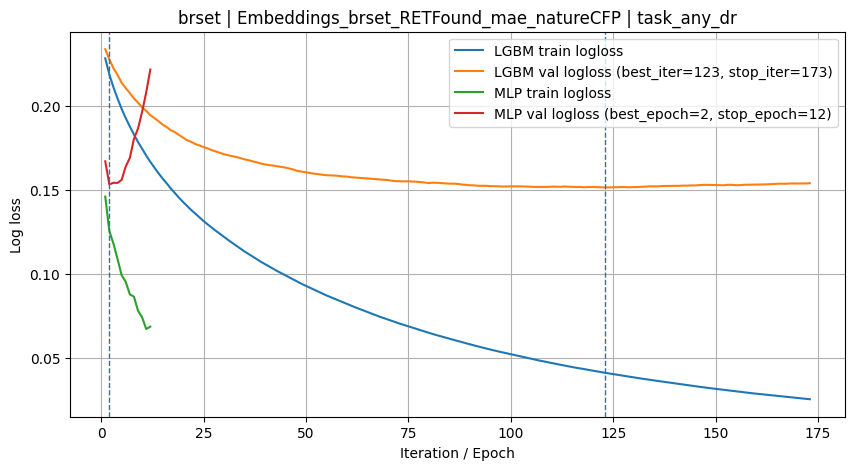

[LightGBM] [Info] Number of positive: 751, number of negative: 12257
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 13008, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.057734 -> initscore=-2.792447
[LightGBM] [Info] Start training from score -2.792447


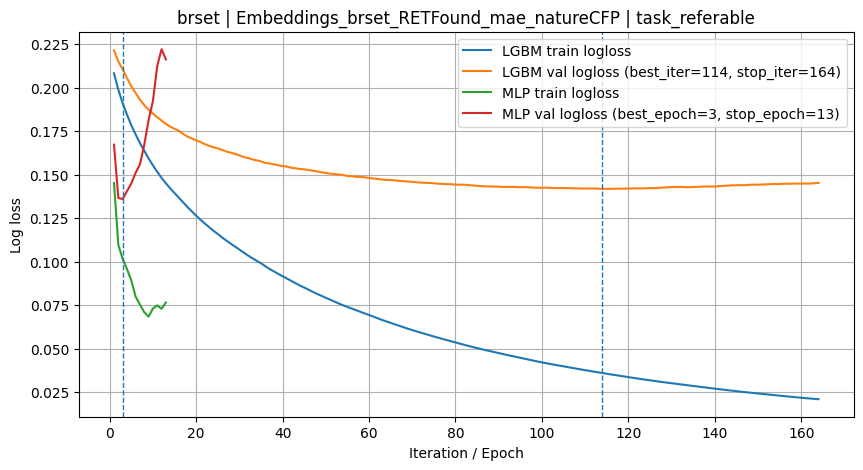

[LightGBM] [Info] Number of positive: 841, number of negative: 12167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 13008, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064653 -> initscore=-2.671891
[LightGBM] [Info] Start training from score -2.671891


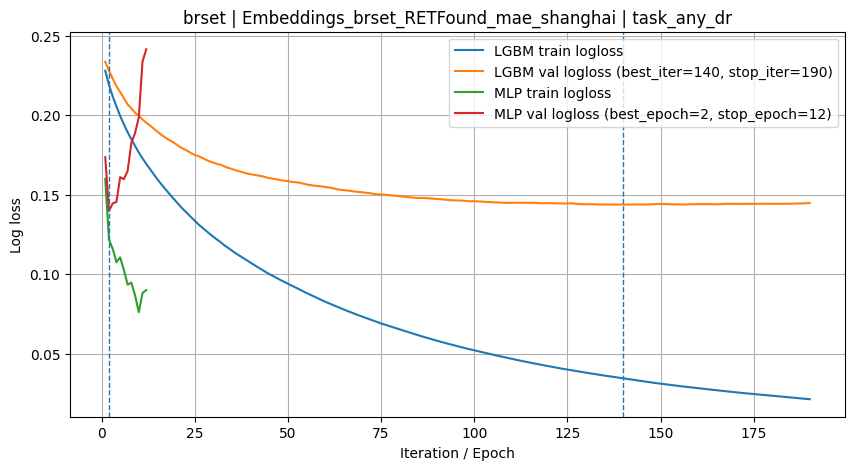

[LightGBM] [Info] Number of positive: 751, number of negative: 12257
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 13008, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.057734 -> initscore=-2.792447
[LightGBM] [Info] Start training from score -2.792447


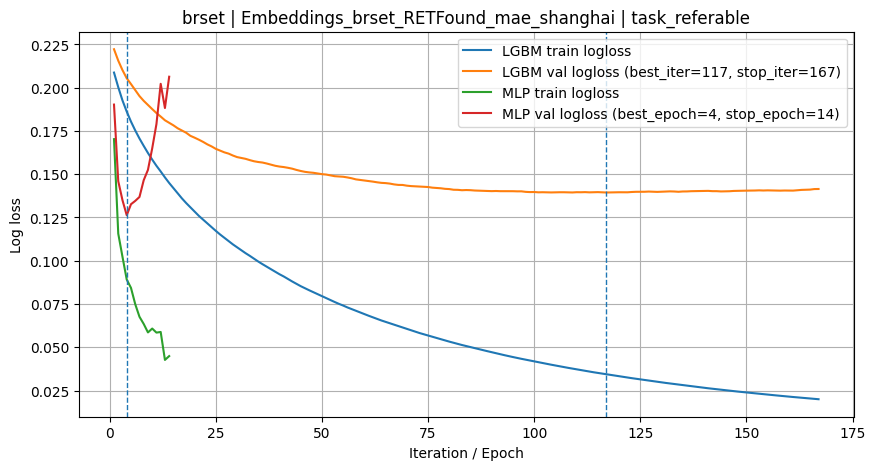

[LightGBM] [Info] Number of positive: 841, number of negative: 12167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 13008, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064653 -> initscore=-2.671891
[LightGBM] [Info] Start training from score -2.671891


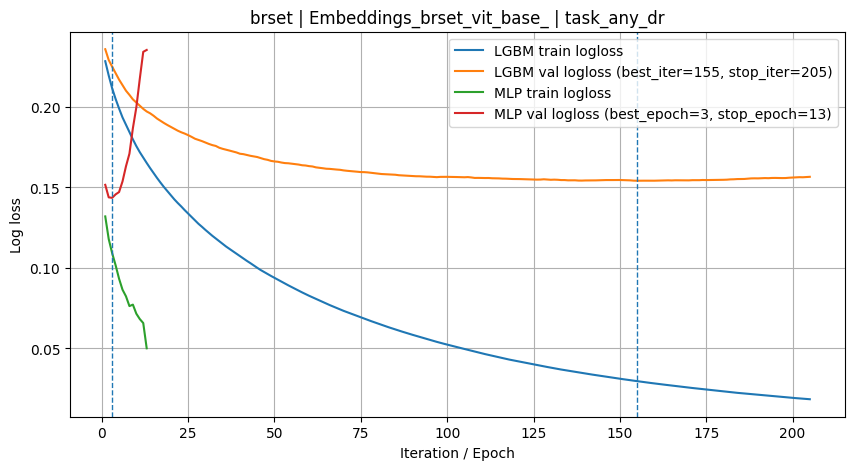

[LightGBM] [Info] Number of positive: 751, number of negative: 12257
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 13008, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.057734 -> initscore=-2.792447
[LightGBM] [Info] Start training from score -2.792447


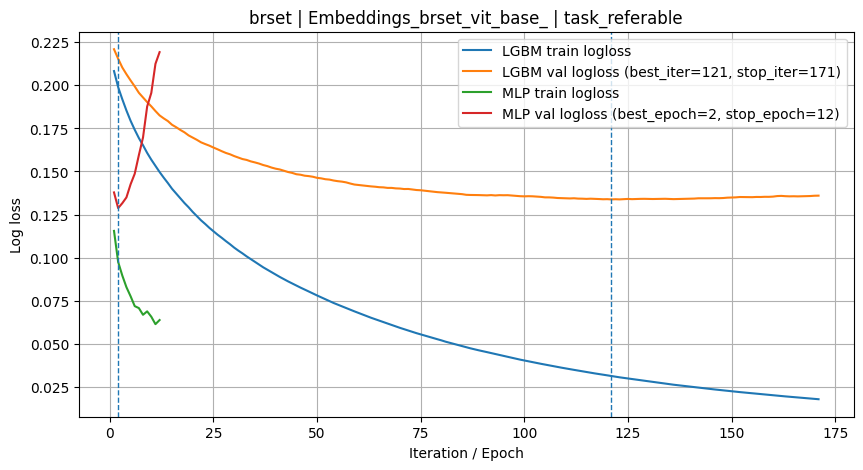

[mbrset] view=macula | Train patients: 1032 | Val patients: 259
[LightGBM] [Info] Number of positive: 469, number of negative: 1595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227229 -> initscore=-1.224026
[LightGBM] [Info] Start training from score -1.224026


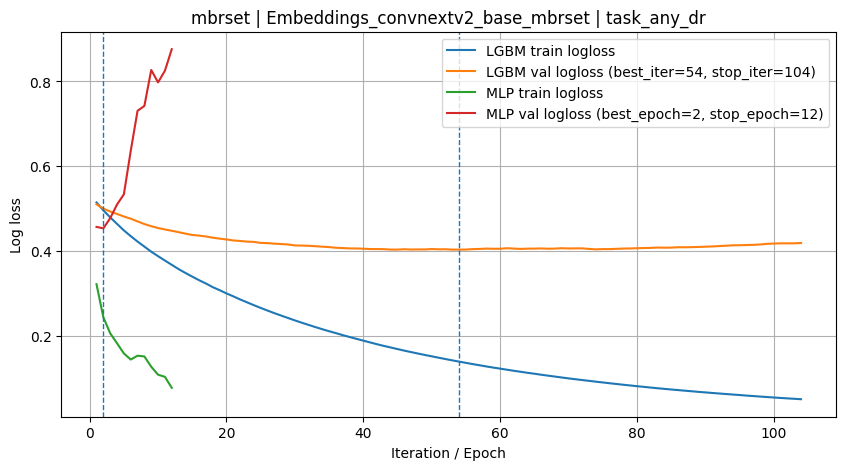

[LightGBM] [Info] Number of positive: 367, number of negative: 1697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177810 -> initscore=-1.531255
[LightGBM] [Info] Start training from score -1.531255


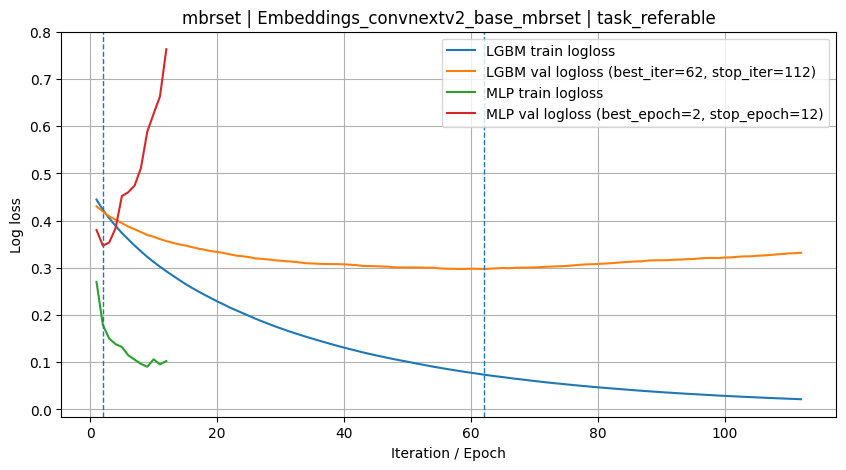

[LightGBM] [Info] Number of positive: 469, number of negative: 1595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227229 -> initscore=-1.224026
[LightGBM] [Info] Start training from score -1.224026


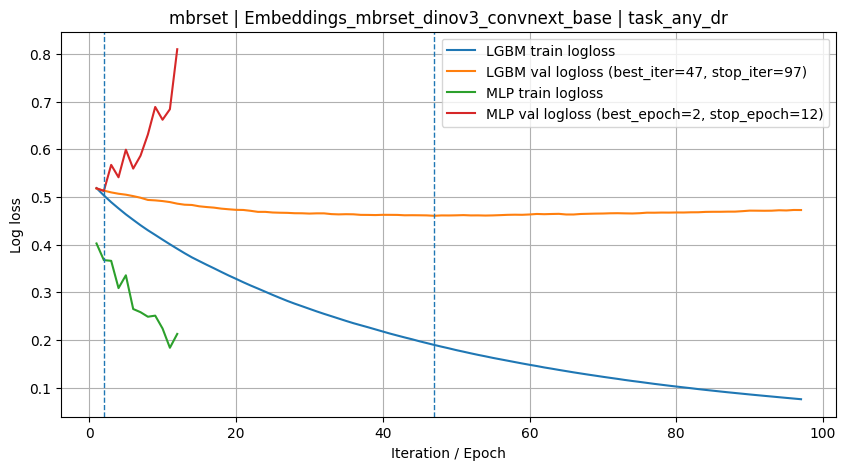

[LightGBM] [Info] Number of positive: 367, number of negative: 1697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177810 -> initscore=-1.531255
[LightGBM] [Info] Start training from score -1.531255


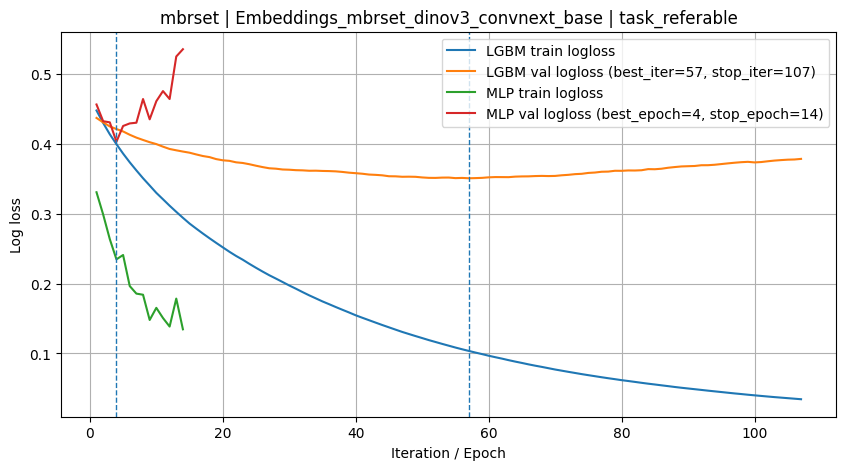

[LightGBM] [Info] Number of positive: 469, number of negative: 1595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227229 -> initscore=-1.224026
[LightGBM] [Info] Start training from score -1.224026


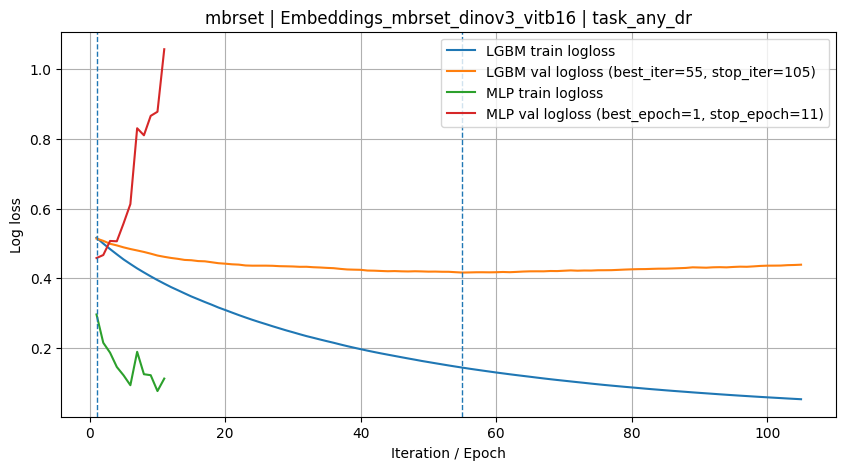

[LightGBM] [Info] Number of positive: 367, number of negative: 1697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177810 -> initscore=-1.531255
[LightGBM] [Info] Start training from score -1.531255


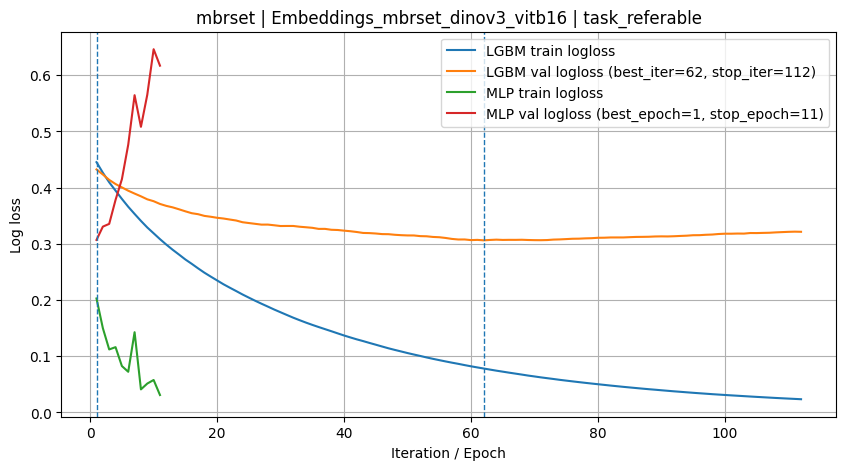

[LightGBM] [Info] Number of positive: 469, number of negative: 1595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227229 -> initscore=-1.224026
[LightGBM] [Info] Start training from score -1.224026


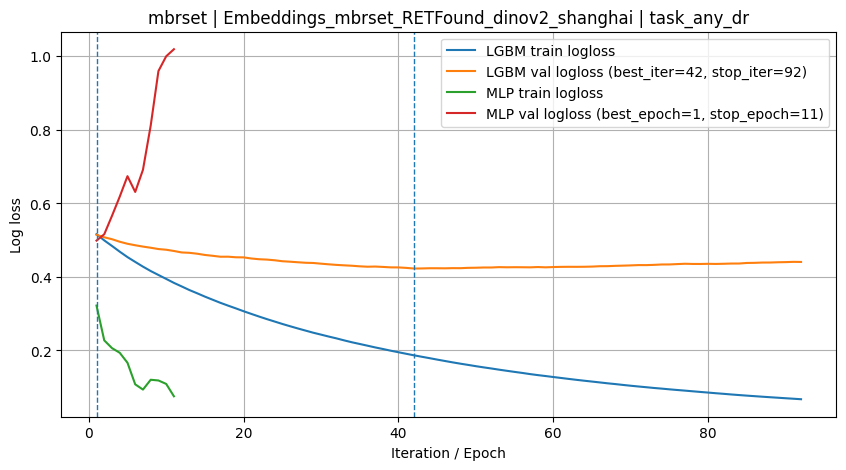

[LightGBM] [Info] Number of positive: 367, number of negative: 1697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177810 -> initscore=-1.531255
[LightGBM] [Info] Start training from score -1.531255


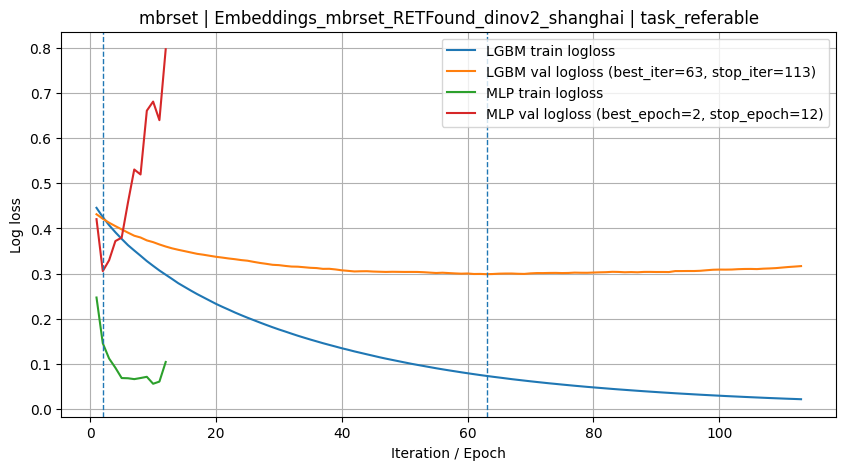

[LightGBM] [Info] Number of positive: 469, number of negative: 1595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227229 -> initscore=-1.224026
[LightGBM] [Info] Start training from score -1.224026


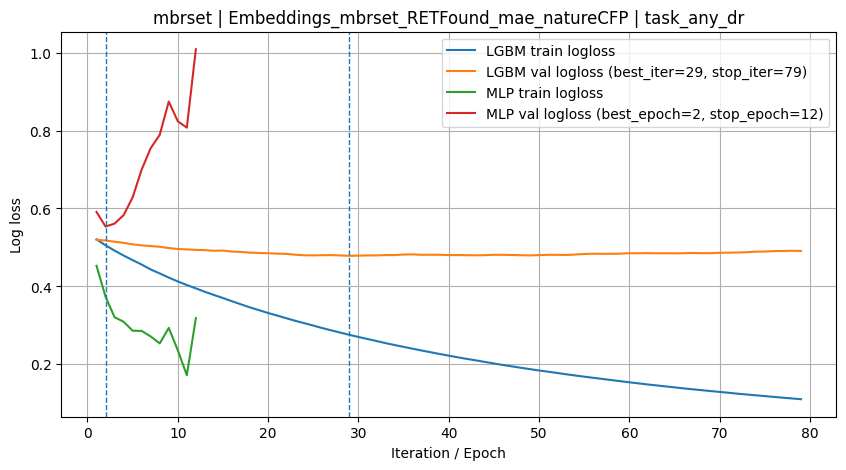

[LightGBM] [Info] Number of positive: 367, number of negative: 1697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177810 -> initscore=-1.531255
[LightGBM] [Info] Start training from score -1.531255


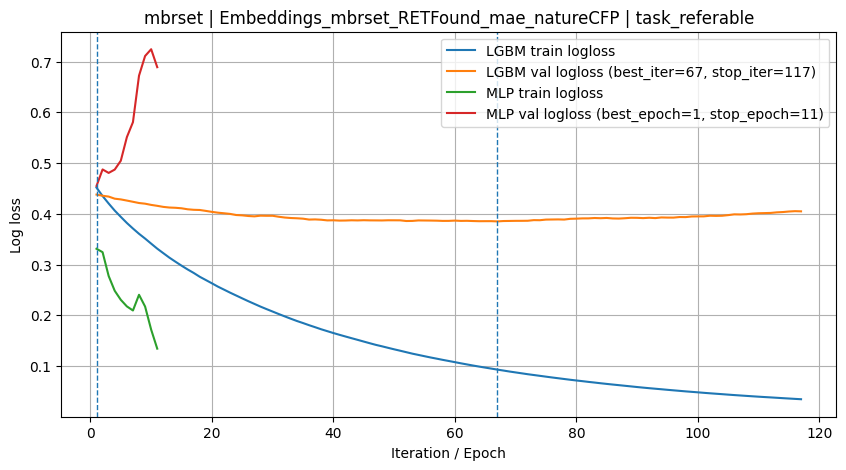

[LightGBM] [Info] Number of positive: 469, number of negative: 1595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227229 -> initscore=-1.224026
[LightGBM] [Info] Start training from score -1.224026


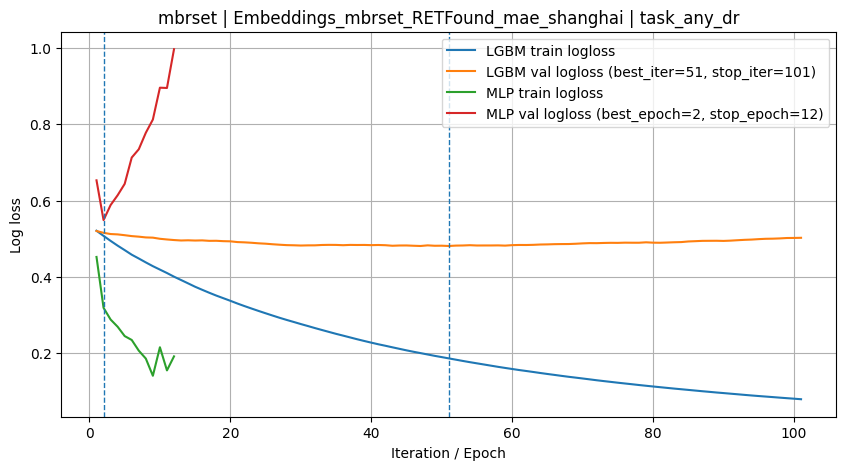

[LightGBM] [Info] Number of positive: 367, number of negative: 1697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177810 -> initscore=-1.531255
[LightGBM] [Info] Start training from score -1.531255


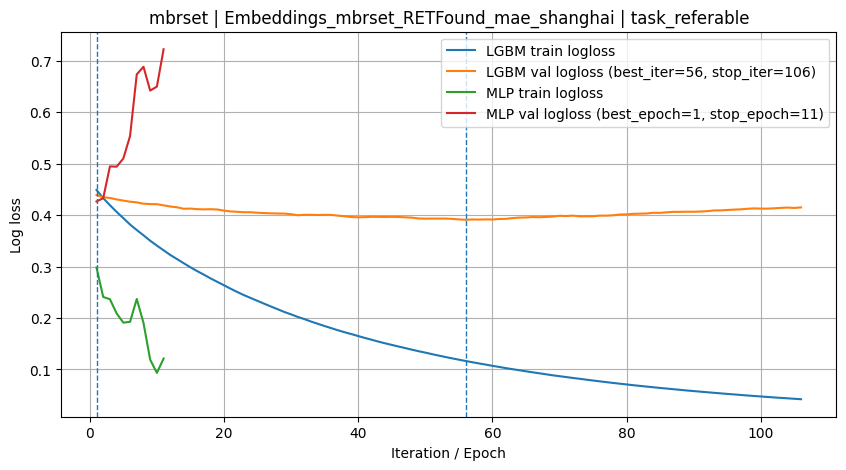

[LightGBM] [Info] Number of positive: 469, number of negative: 1595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227229 -> initscore=-1.224026
[LightGBM] [Info] Start training from score -1.224026


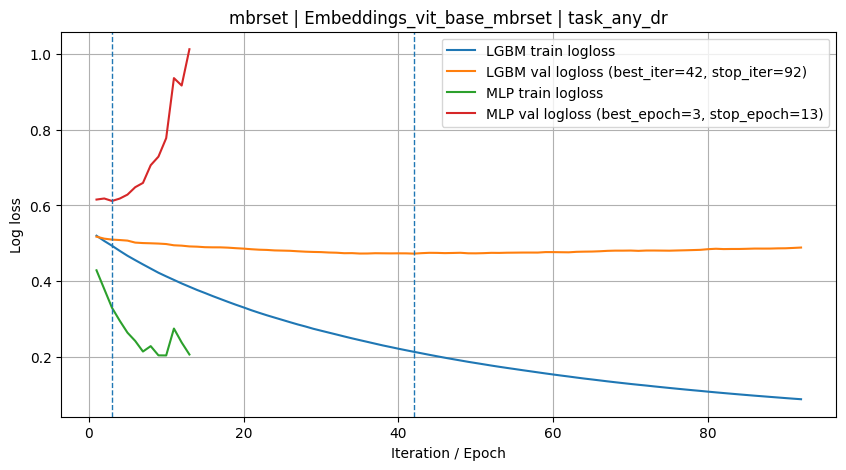

[LightGBM] [Info] Number of positive: 367, number of negative: 1697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177810 -> initscore=-1.531255
[LightGBM] [Info] Start training from score -1.531255


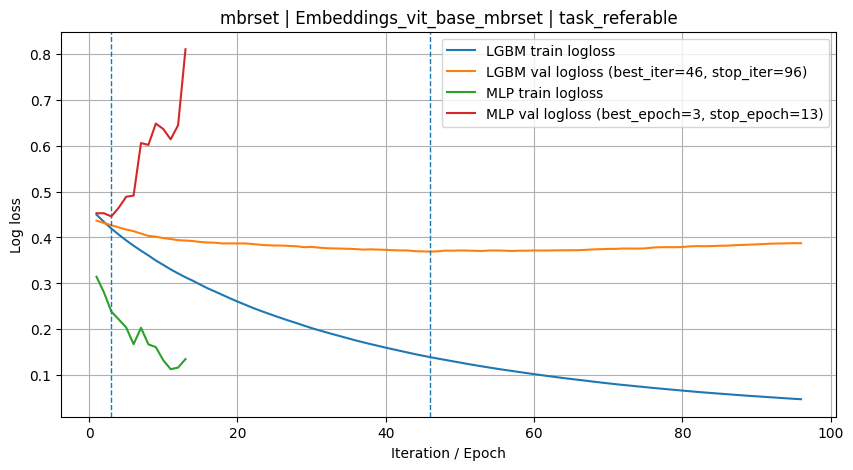

In [9]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# training-dynamics plots (with early stopping)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

RANDOM_SEED = 42
VAL_FRAC = 0.2

CPU_COUNT = os.cpu_count() or 1

LGBM_MAX_ITERS = 800
LGBM_EARLY_STOPPING_ROUNDS = 50
LGBM_LEARNING_RATE = 0.05

MLP_MAX_EPOCHS = 200
MLP_EARLY_STOPPING_PATIENCE = 10
MLP_MIN_DELTA = 1e-6

MAX_EMBEDDINGS_PER_DATASET = None  # set to 1 or 2 for faster plotting
ONLY_TASKS = None  # e.g. ["task_any_dr"]

for cfg in DATASETS:
    dataset_name, view = cfg["name"], cfg["view"]
    embed_dir = PROJECT_ROOT / "data" / f"{dataset_name}_embeddings"
    labels_path = embed_dir / f"{dataset_name}_labels" / f"labels_{dataset_name}.csv"
    embedding_files = list_embeddings_csvs(embed_dir)
    if not embedding_files:
        continue
    if MAX_EMBEDDINGS_PER_DATASET is not None:
        embedding_files = embedding_files[:MAX_EMBEDDINGS_PER_DATASET]

    base_ds = load_retina_embeddings_dataset(
        dataset=dataset_name,
        embeddings_csv_path=embedding_files[0],
        labels_csv_path=labels_path,
        view=view,
    )
    split = reval.make_patient_split(
        df=base_ds.df,
        group_col="patient_id",
        label_col="task_any_dr",
        val_frac=VAL_FRAC,
        seed=RANDOM_SEED,
    )
    print(f"[{dataset_name}] view={view} | Train patients: {len(split.train_patient_ids)} | Val patients: {len(split.val_patient_ids)}")

    for emb_path in embedding_files:
        ds = load_retina_embeddings_dataset(
            dataset=dataset_name,
            embeddings_csv_path=emb_path,
            labels_csv_path=labels_path,
            view=view,
        )
        train_df, val_df = reval.apply_patient_split(ds.df, split, group_col="patient_id")

        tasks = [t for t in BINARY_TASKS if t in ds.df.columns]
        if ONLY_TASKS is not None:
            tasks = [t for t in tasks if t in ONLY_TASKS]
        if not tasks:
            continue

        for task in tasks:
            train_work = train_df.dropna(subset=[task]).copy()
            val_work = val_df.dropna(subset=[task]).copy()
            if train_work.empty or val_work.empty:
                continue

            X_train = train_work[ds.feature_cols].to_numpy(dtype=np.float32)
            y_train = train_work[task].to_numpy(dtype=int)
            X_val = val_work[ds.feature_cols].to_numpy(dtype=np.float32)
            y_val = val_work[task].to_numpy(dtype=int)
            labels = np.unique(np.concatenate([y_train, y_val]))

            # --- LightGBM with early stopping ---
            lgbm = LGBMClassifier(
                n_estimators=LGBM_MAX_ITERS,
                learning_rate=LGBM_LEARNING_RATE,
                random_state=RANDOM_SEED,
                n_jobs=CPU_COUNT,
                num_threads=CPU_COUNT,
            )
            lgbm.fit(
                X_train,
                y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                eval_names=["train", "val"],
                eval_metric="binary_logloss",
                callbacks=[
                    early_stopping(
                        stopping_rounds=LGBM_EARLY_STOPPING_ROUNDS,
                        first_metric_only=True,
                        verbose=False,
                    ),
                    log_evaluation(period=0),
                ],
            )
            lgbm_eval = lgbm.evals_result_
            lgbm_train_loss = lgbm_eval["train"]["binary_logloss"]
            lgbm_val_loss = lgbm_eval["val"]["binary_logloss"]
            lgbm_best_iter = int(getattr(lgbm, "best_iteration_", np.argmin(lgbm_val_loss) + 1))
            lgbm_stop_iter = len(lgbm_val_loss)

            # --- MLP with manual patience early stopping (epoch loop) ---
            mlp_pipe = Pipeline(
                steps=[
                    ("scaler", StandardScaler()),
                    (
                        "mlp",
                        MLPClassifier(
                            hidden_layer_sizes=(256,),
                            activation="relu",
                            solver="adam",
                            batch_size=32,
                            learning_rate_init=1e-3,
                            alpha=1e-4,
                            max_iter=1,
                            warm_start=True,
                            early_stopping=False,
                            random_state=RANDOM_SEED,
                        ),
                    ),
                ]
            )

            mlp_train_loss = []
            mlp_val_loss = []
            best_val = float("inf")
            best_epoch = 0
            no_improve = 0

            for epoch in range(1, MLP_MAX_EPOCHS + 1):
                mlp_pipe.fit(X_train, y_train)
                p_train = mlp_pipe.predict_proba(X_train)
                p_val = mlp_pipe.predict_proba(X_val)
                tr_loss = float(log_loss(y_train, p_train, labels=labels))
                va_loss = float(log_loss(y_val, p_val, labels=labels))
                mlp_train_loss.append(tr_loss)
                mlp_val_loss.append(va_loss)

                if va_loss < best_val - MLP_MIN_DELTA:
                    best_val = va_loss
                    best_epoch = epoch
                    no_improve = 0
                else:
                    no_improve += 1
                    if no_improve >= MLP_EARLY_STOPPING_PATIENCE:
                        break

            mlp_stop_epoch = len(mlp_val_loss)

            # --- Plot ---
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
            ax.plot(range(1, len(lgbm_train_loss) + 1), lgbm_train_loss, label="LGBM train logloss")
            ax.plot(
                range(1, len(lgbm_val_loss) + 1),
                lgbm_val_loss,
                label=f"LGBM val logloss (best_iter={lgbm_best_iter}, stop_iter={lgbm_stop_iter})",
            )
            ax.axvline(lgbm_best_iter, linestyle="--", linewidth=1)

            ax.plot(range(1, len(mlp_train_loss) + 1), mlp_train_loss, label="MLP train logloss")
            ax.plot(
                range(1, len(mlp_val_loss) + 1),
                mlp_val_loss,
                label=f"MLP val logloss (best_epoch={best_epoch}, stop_epoch={mlp_stop_epoch})",
            )
            ax.axvline(best_epoch, linestyle="--", linewidth=1)

            ax.set_title(f"{dataset_name} | {emb_path.stem} | {task}")
            ax.set_xlabel("Iteration / Epoch")
            ax.set_ylabel("Log loss")
            ax.legend()
            ax.grid(True)
            plt.show()

## 6b) Training dynamics for MBRSET only

Duplicates Section 6 but runs *only* on MBRSET to quickly check overfitting (train vs validation curves).

[mbrset] view=macula | Train patients: 1032 | Val patients: 259


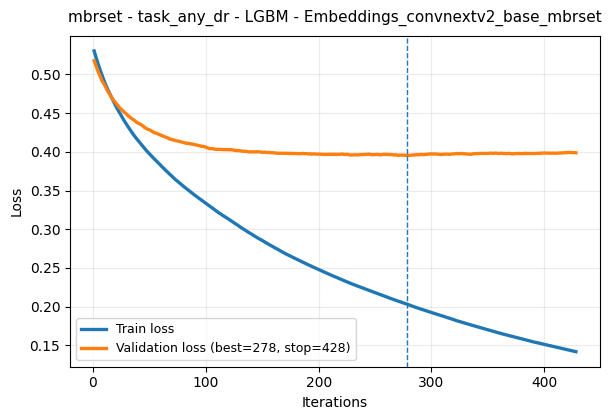

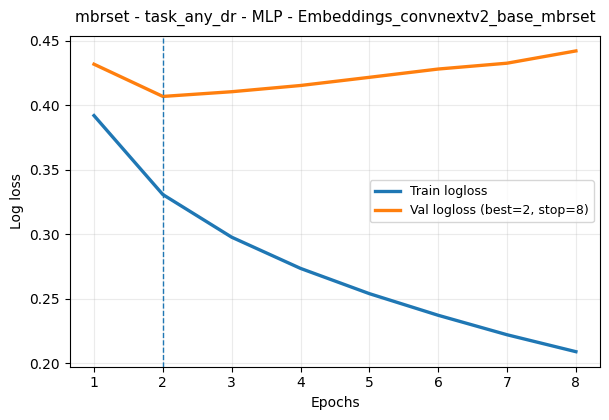

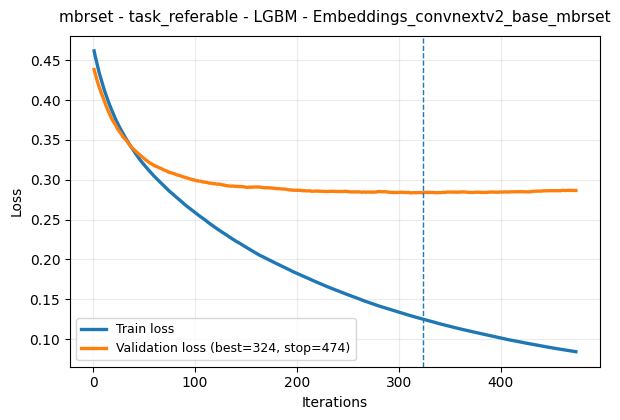

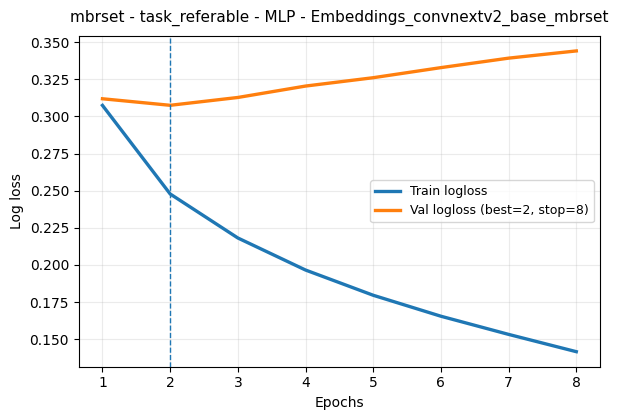

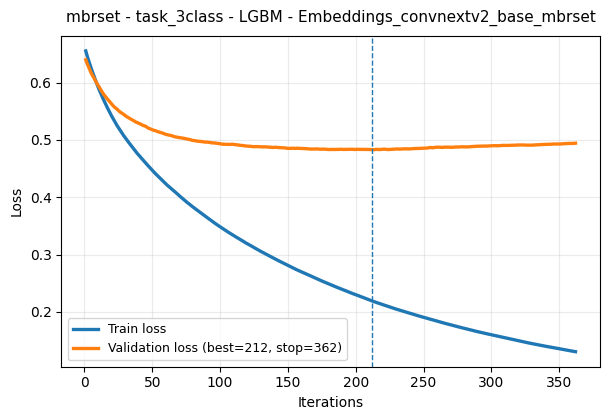

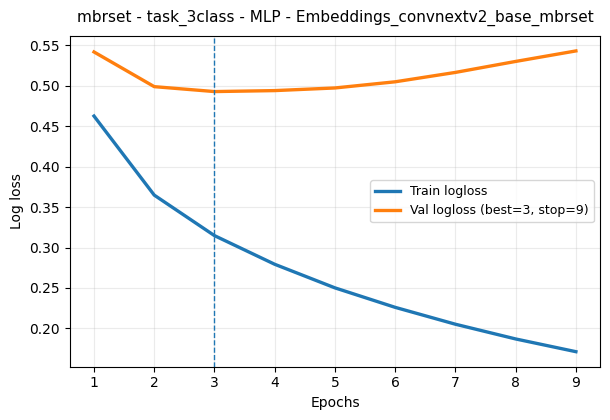

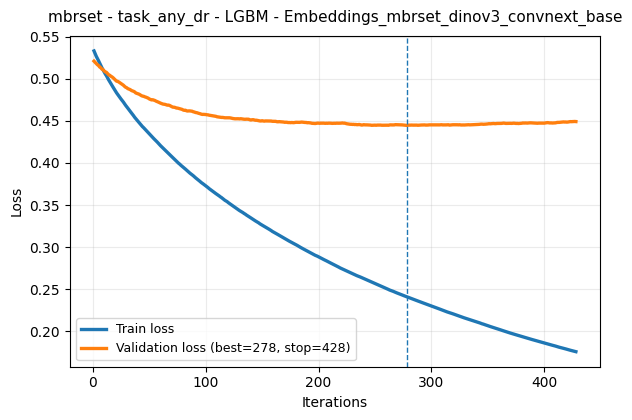

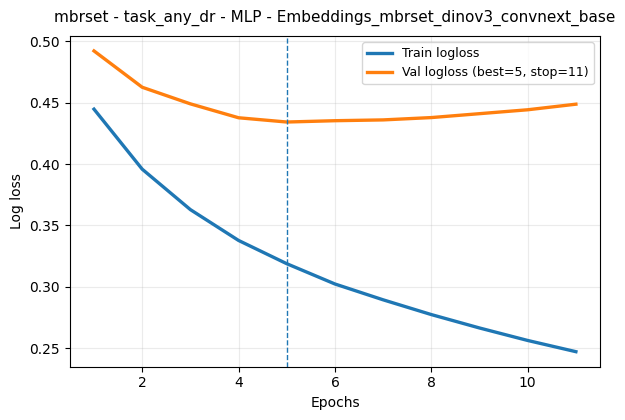

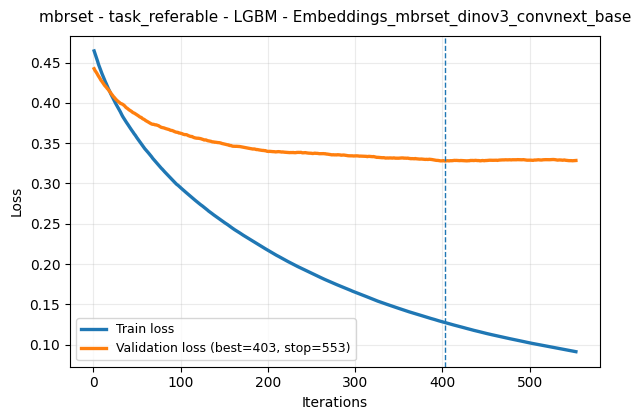

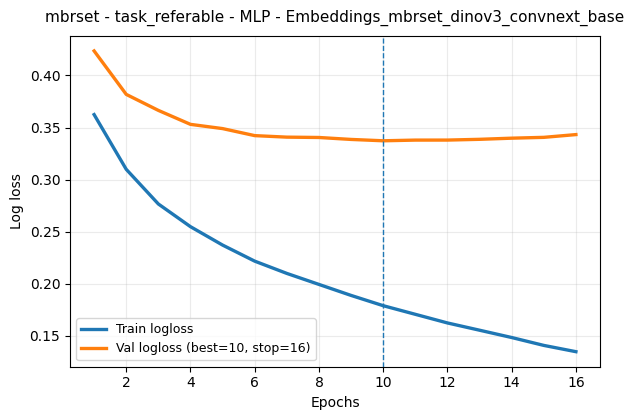

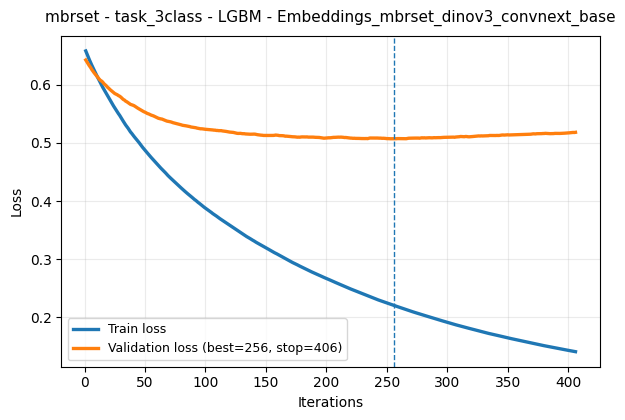

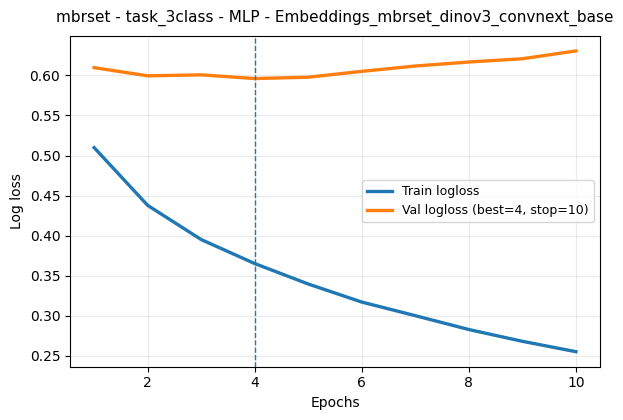

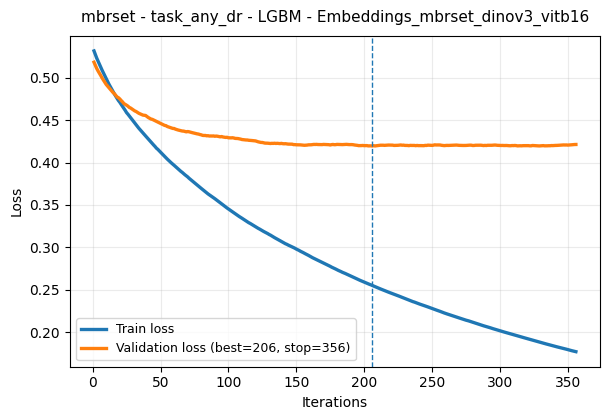

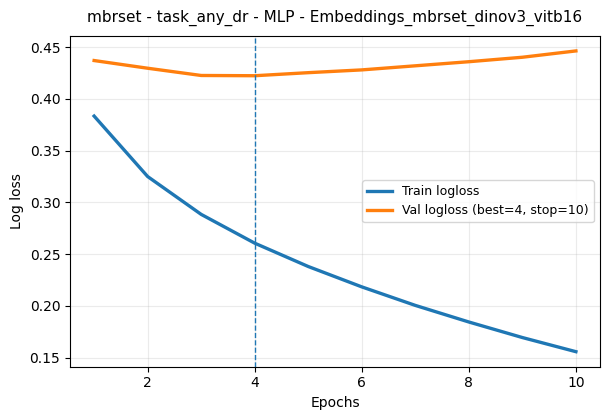

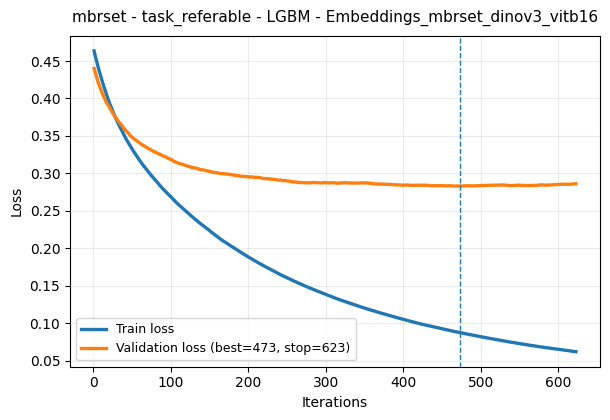

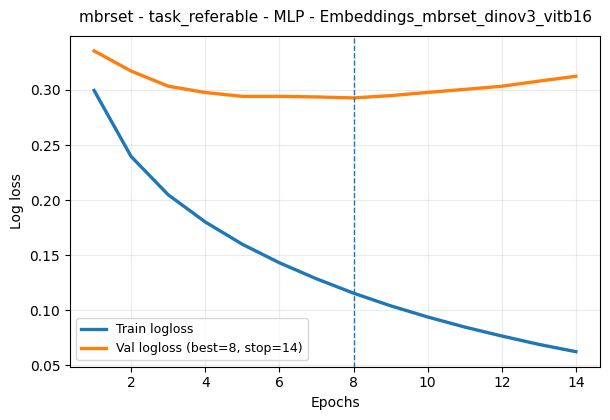

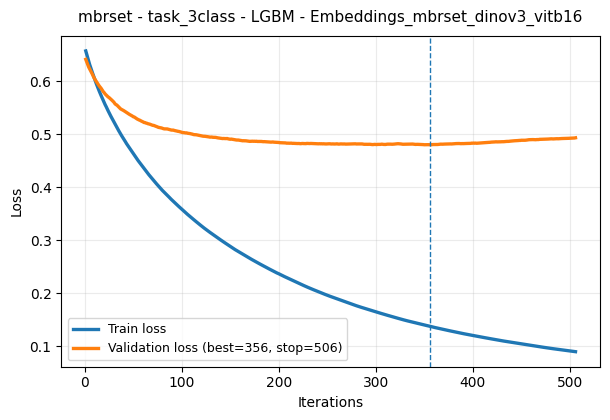

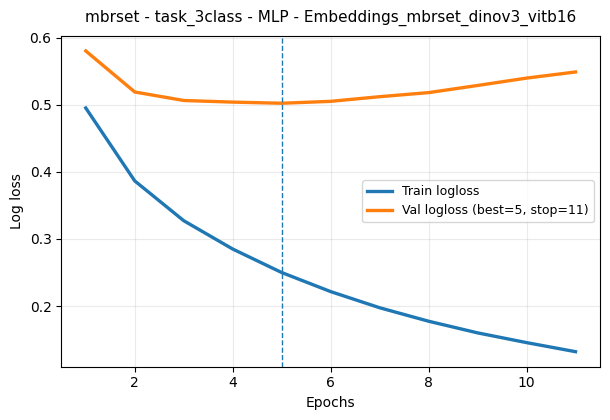

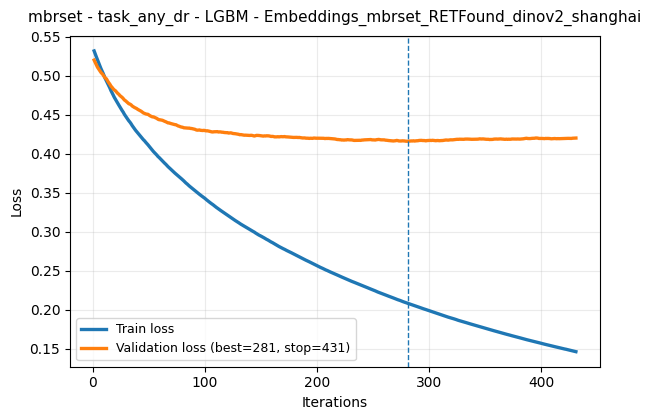

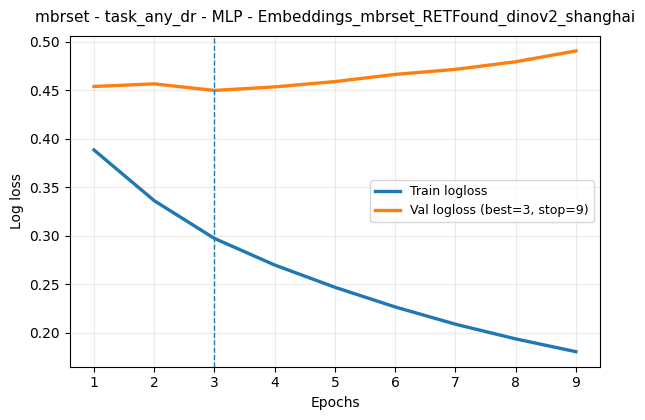

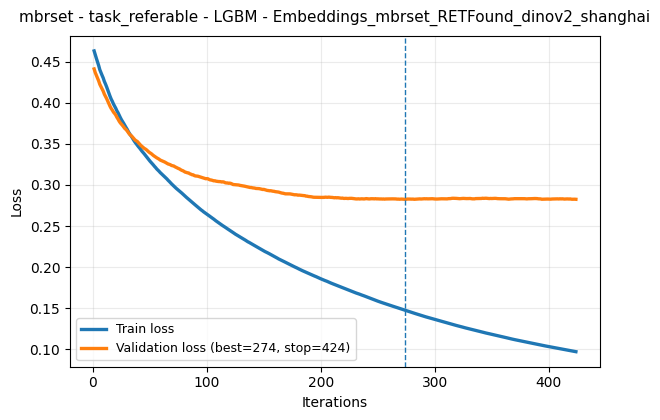

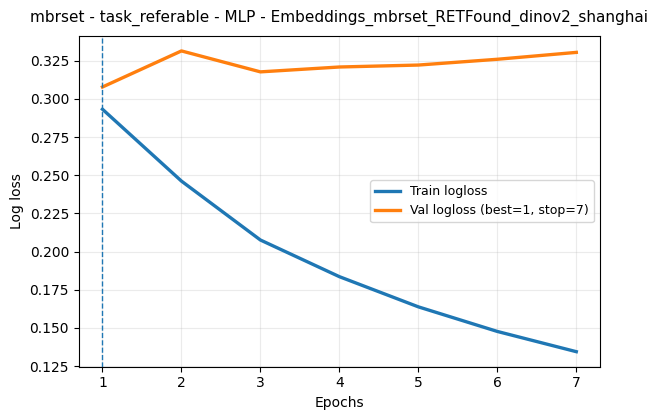

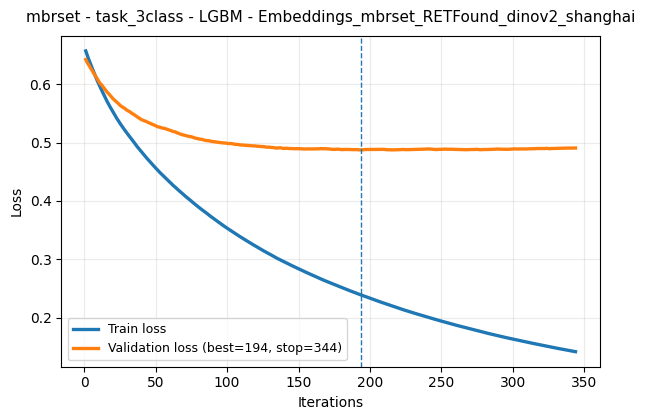

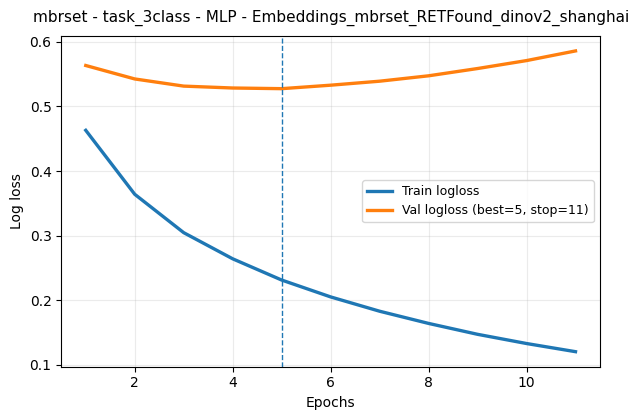

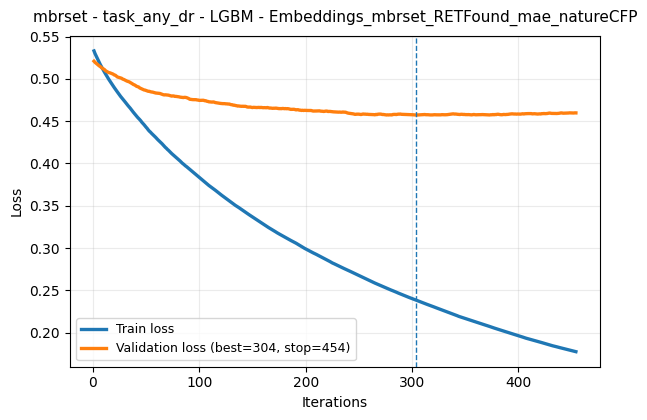

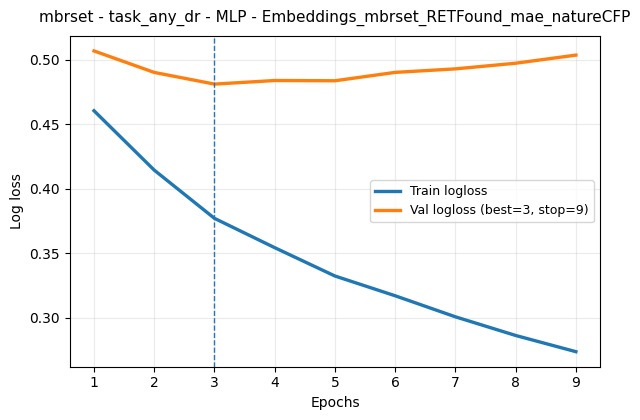

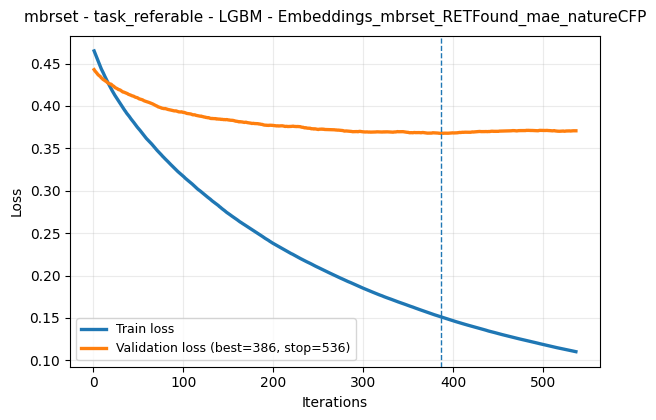

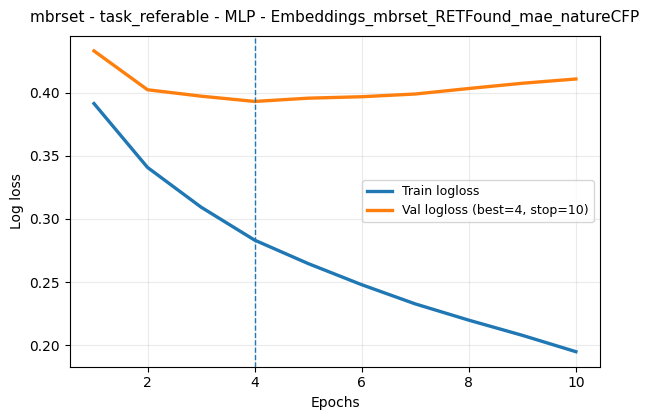

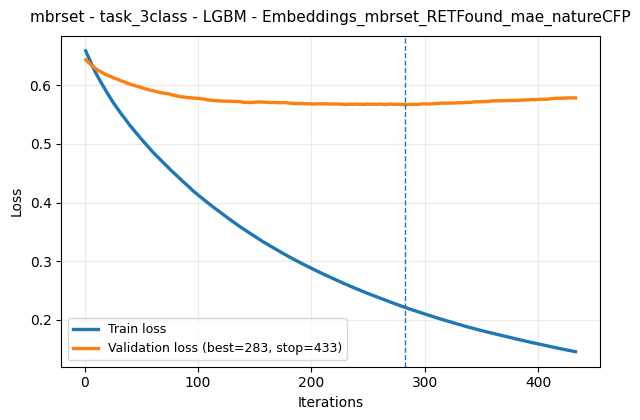

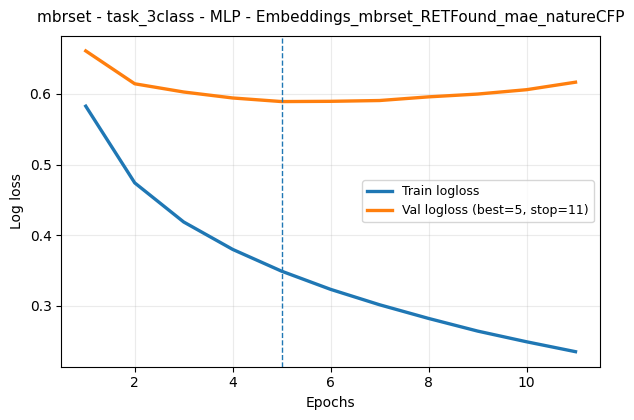

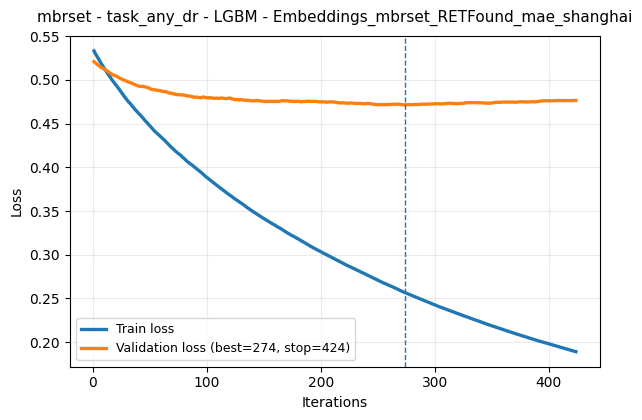

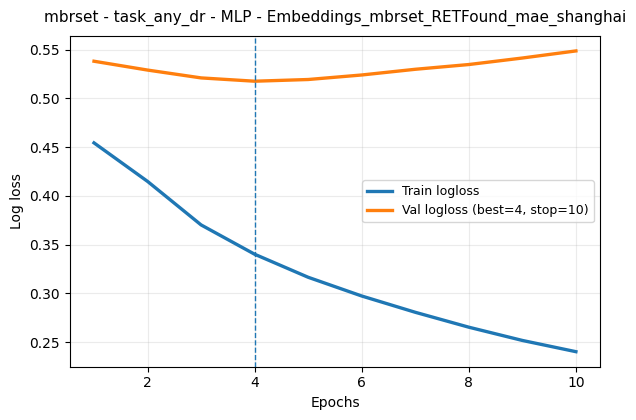

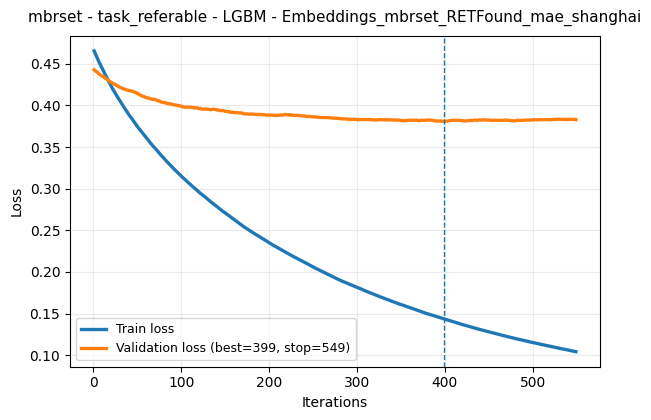

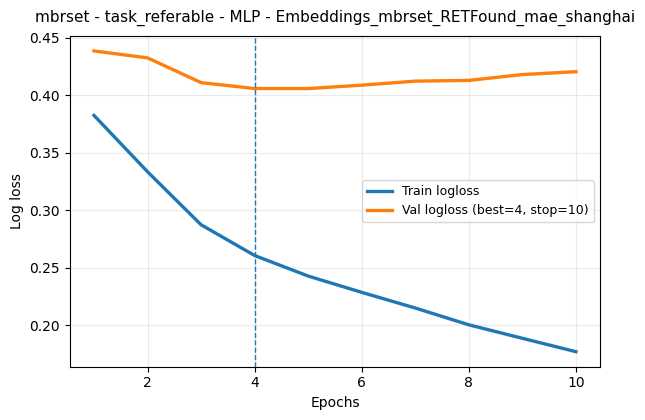

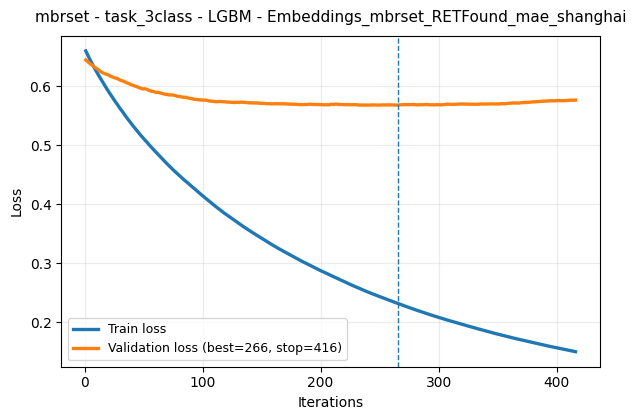

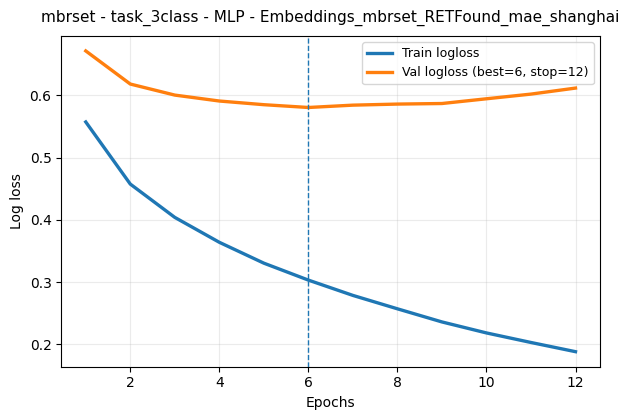

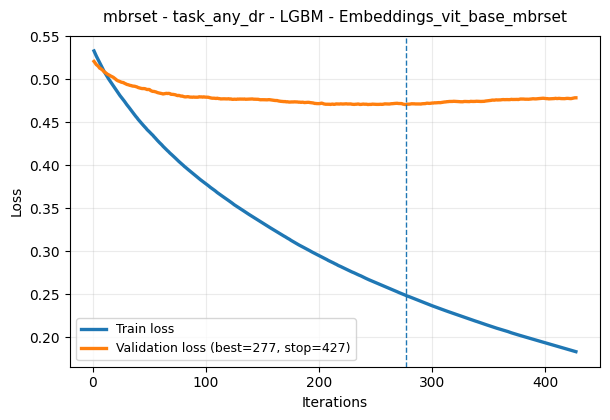

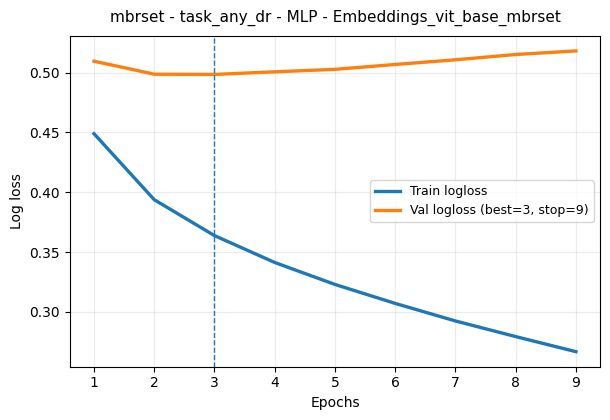

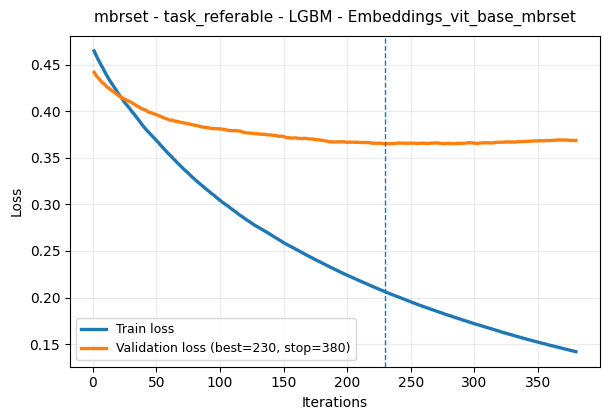

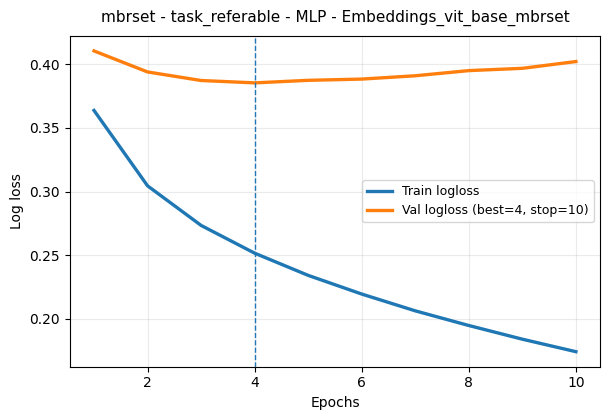

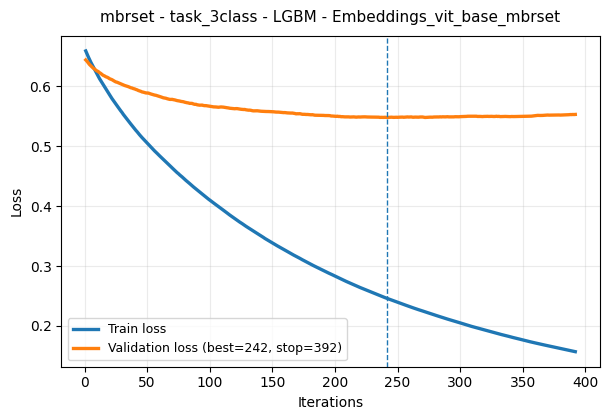

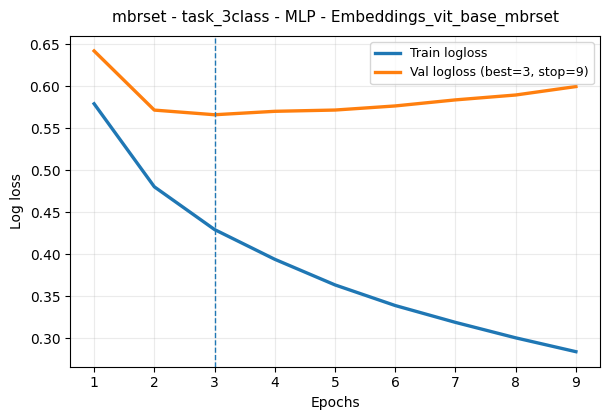

In [19]:
# Training dynamics per embedding (MBRSET-only) — WITH early stopping
# This is a copy of Section 6 with the loop restricted to MBRSET, and it stops when validation stops improving.

import copy
import os
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import early_stopping, log_evaluation
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore", category=ConvergenceWarning)

CPU_COUNT = os.cpu_count() or 1

def _safe_plot_name(text: str, max_len: int = 60) -> str:
    slug = re.sub(r"[^a-zA-Z0-9._-]+", "_", text).strip("_")
    return slug[:max_len] if slug else "plot"

def _short_task_name(task: str) -> str:
    mapping = {
        "task_any_diab_retino": "any_dr",
        "task_ref_macular": "referable",
        "task_any_dr": "any_dr",
        "task_referable": "referable",
        "task_3class": "3class",
    }
    return mapping.get(task, _safe_plot_name(task, max_len=20))

SHOW_PLOTS = True
SAVE_PLOTS = True
PLOTS_DIR = PROJECT_ROOT / "results"

# --- MLP tuning to reduce overfitting ---
# Smaller network, stronger L2, lower lr, slightly larger batch to smooth updates.
MLP_MAX_EPOCHS = 320
MLP_EARLY_STOPPING_PATIENCE = 6
MLP_MIN_DELTA = 1e-4
MLP_HIDDEN_LAYER_SIZES = (128,)
MLP_ALPHA = 1e-2
MLP_LEARNING_RATE_INIT = 3e-4
MLP_BATCH_SIZE = 64

# --- LightGBM tuning to reduce overfitting gap ---
# Fewer leaves, heavier regularization, more bagging/feature subsampling.
LGBM_N_ESTIMATORS = 1200
LGBM_EARLY_STOPPING_ROUNDS = 150
LGBM_NUM_LEAVES = 15
LGBM_MIN_CHILD_SAMPLES = 150
LGBM_REG_LAMBDA = 6.0
LGBM_REG_ALPHA = 0.8
LGBM_SUBSAMPLE = 0.65
LGBM_COLSAMPLE = 0.65

ONLY_TASKS = None  # set e.g. ["task_any_diab_retino"] for faster runs
MAX_EMBEDDINGS_PER_DATASET = None  # run all embeddings

PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# --- Restrict to MBRSET only ---
target_dataset = "mbrset"
cfg = next((c for c in DATASETS if c.get("name") == target_dataset), None)
if cfg is None:
    raise ValueError(f"Dataset '{target_dataset}' not found in DATASETS: {DATASETS}")

dataset_name = cfg["name"]
view = cfg["view"]
embed_dir, labels_path = _paths_for_dataset(dataset_name)
embedding_files = list_embeddings_csvs(embed_dir)
if not embedding_files:
    raise FileNotFoundError(f"No embedding CSV files found under {embed_dir}")
if MAX_EMBEDDINGS_PER_DATASET is not None:
    embedding_files = embedding_files[: int(MAX_EMBEDDINGS_PER_DATASET)]

dataset_dir = PLOTS_DIR / dataset_name
dataset_dir.mkdir(parents=True, exist_ok=True)

# One split reused across embeddings
base_ds = load_retina_embeddings_dataset(
    dataset=dataset_name,
    embeddings_csv_path=embedding_files[0],
    labels_csv_path=labels_path,
    view=view,
)
split = reval.make_patient_split(
    df=base_ds.df,
    group_col="patient_id",
    label_col="task_any_dr",
    val_frac=VAL_FRAC,
    seed=RANDOM_SEED,
)
print(f"[{dataset_name}] view={view} | Train patients: {len(split.train_patient_ids)} | Val patients: {len(split.val_patient_ids)}")

tasks = list(BINARY_TASKS)
if "task_3class" in base_ds.df.columns:
    tasks.append("task_3class")
if ONLY_TASKS is not None:
    tasks = [t for t in tasks if t in set(ONLY_TASKS)]

# Save an index map for this dataset (short paths -> embedding names)
index_rows = []
for emb_idx, emb_path in enumerate(embedding_files):
    index_rows.append({"index": emb_idx, "embedding": emb_path.stem})
pd.DataFrame(index_rows).to_csv(dataset_dir / "embedding_index.csv", index=False)

for emb_idx, emb_path in enumerate(embedding_files):
    ds = load_retina_embeddings_dataset(
        dataset=dataset_name,
        embeddings_csv_path=emb_path,
        labels_csv_path=labels_path,
        view=view,
    )
    train_df, val_df = reval.apply_patient_split(ds.df, split, group_col="patient_id")

    emb_dir = f"{emb_idx:02d}"

    for task in tasks:
        if task not in ds.df.columns:
            continue
        task_type = "binary" if task in BINARY_TASKS else "multiclass"
        display_task = BINARY_TASK_MAP.get(task, task)
        task_slug = _short_task_name(display_task)

        train_work = train_df.dropna(subset=[task]).copy()
        val_work = val_df.dropna(subset=[task]).copy()
        if train_work.empty or val_work.empty:
            continue

        X_train = train_work.loc[:, ds.feature_cols].to_numpy(dtype=np.float32)
        y_train = train_work[task].astype(int).to_numpy()
        X_val = val_work.loc[:, ds.feature_cols].to_numpy(dtype=np.float32)
        y_val = val_work[task].astype(int).to_numpy()
        labels = np.unique(np.concatenate([y_train, y_val]))

        # --- LGBM per-embedding plot (EARLY STOPPING) ---
        lgbm = reval._make_model("lgbm", random_state=RANDOM_SEED)
        try:
            lgbm.set_params(
                n_estimators=int(LGBM_N_ESTIMATORS),
                n_jobs=CPU_COUNT,
                num_threads=CPU_COUNT,
                num_leaves=int(LGBM_NUM_LEAVES),
                min_child_samples=int(LGBM_MIN_CHILD_SAMPLES),
                reg_lambda=float(LGBM_REG_LAMBDA),
                reg_alpha=float(LGBM_REG_ALPHA),
                subsample=float(LGBM_SUBSAMPLE),
                colsample_bytree=float(LGBM_COLSAMPLE),
            )
        except Exception:
            pass

        eval_metric = "binary_logloss" if task_type == "binary" else "multi_logloss"
        lgbm.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_names=["train", "val"],
            eval_metric=eval_metric,
            callbacks=[
                early_stopping(
                    stopping_rounds=LGBM_EARLY_STOPPING_ROUNDS,
                    first_metric_only=True,
                    verbose=False,
                ),
                log_evaluation(period=0),
            ],
        )
        res = getattr(lgbm, "evals_result_", None)
        if res:
            train_series = res.get("train", {}).get(eval_metric, [])
            val_series = res.get("val", {}).get(eval_metric, [])
            best_iter = int(getattr(lgbm, "best_iteration_", np.argmin(val_series) + 1)) if val_series else None
            stop_iter = len(val_series)

            iters = np.arange(1, 1 + max(len(train_series), len(val_series)))
            fig, ax = plt.subplots(figsize=(6.2, 4.3))
            if train_series:
                ax.plot(iters[: len(train_series)], train_series, label="Train loss", linewidth=2.4)
            if val_series:
                ax.plot(iters[: len(val_series)], val_series, label=f"Validation loss (best={best_iter}, stop={stop_iter})", linewidth=2.4)
            if best_iter is not None:
                ax.axvline(best_iter, linestyle="--", linewidth=1)
            ax.set_xlabel("Iterations", fontsize=10)
            ax.set_ylabel("Loss", fontsize=10)
            ax.set_title(f"{dataset_name} - {task} - LGBM - {emb_path.stem}", fontsize=11, pad=10)
            ax.grid(True, alpha=0.25)
            ax.legend(fontsize=9)
            plt.tight_layout()
            if SAVE_PLOTS:
                out_dir = dataset_dir / emb_dir / task_slug
                out_dir.mkdir(parents=True, exist_ok=True)
                out_path = out_dir / f"lgbm_{task_slug}.png"
                fig.savefig(out_path, dpi=160, bbox_inches="tight")
            if SHOW_PLOTS:
                plt.show()
            else:
                plt.close(fig)

        # --- MLP per-embedding plot (PATIENCE EARLY STOPPING + BEST-EPOCH RESTORE) ---
        base_model = reval._make_model("mlp", random_state=RANDOM_SEED)
        scaler = base_model.named_steps.get("scaler") if hasattr(base_model, "named_steps") else StandardScaler()
        clf_base = base_model.named_steps.get("clf") if hasattr(base_model, "named_steps") else base_model
        params = clf_base.get_params()
        params.update(
            {
                "warm_start": True,
                "max_iter": 1,
                "early_stopping": False,
                "batch_size": MLP_BATCH_SIZE,
                "hidden_layer_sizes": MLP_HIDDEN_LAYER_SIZES,
                "alpha": float(MLP_ALPHA),
                "learning_rate_init": float(MLP_LEARNING_RATE_INIT),
            }
        )
        loop_clf = MLPClassifier(**params)

        X_train_s = scaler.fit_transform(X_train)
        X_val_s = scaler.transform(X_val)

        train_loss = []
        val_loss = []
        best_val = float("inf")
        best_epoch = 0
        best_model = None
        no_improve = 0

        for epoch in range(1, MLP_MAX_EPOCHS + 1):
            loop_clf.fit(X_train_s, y_train)
            p_train = loop_clf.predict_proba(X_train_s)
            p_val = loop_clf.predict_proba(X_val_s)
            tr = float(log_loss(y_train, p_train, labels=labels))
            va = float(log_loss(y_val, p_val, labels=labels))
            train_loss.append(tr)
            val_loss.append(va)

            if va < best_val - MLP_MIN_DELTA:
                best_val = va
                best_epoch = epoch
                best_model = copy.deepcopy(loop_clf)
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= MLP_EARLY_STOPPING_PATIENCE:
                    break

        # Restore best epoch weights so the final model == best epoch
        if best_model is not None:
            loop_clf = best_model

        epochs = np.arange(1, len(train_loss) + 1)
        fig, ax = plt.subplots(figsize=(6.2, 4.3))
        ax.plot(epochs, train_loss, label="Train logloss", linewidth=2.4)
        ax.plot(epochs, val_loss, label=f"Val logloss (best={best_epoch}, stop={len(val_loss)})", linewidth=2.4)
        if best_epoch:
            ax.axvline(best_epoch, linestyle="--", linewidth=1)
        ax.set_xlabel("Epochs", fontsize=10)
        ax.set_ylabel("Log loss", fontsize=10)
        ax.set_title(f"{dataset_name} - {task} - MLP - {emb_path.stem}", fontsize=11, pad=10)
        ax.grid(True, alpha=0.25)
        ax.legend(fontsize=9)
        plt.tight_layout()
        if SAVE_PLOTS:
            out_dir = dataset_dir / emb_dir / task_slug
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / f"mlp_{task_slug}.png"
            fig.savefig(out_path, dpi=160, bbox_inches="tight")
        if SHOW_PLOTS:
            plt.show()
        else:
            plt.close(fig)


## 7) Detailed evaluation for ALL embeddings

Generates classification reports, confusion matrices, and ROC curves (binary tasks only) for every embedding/model/task.
Outputs are saved under results/detailed_eval/all_embeddings/.

In [10]:
# Detailed evaluation for all embeddings (MBRSET-only) (save reports + plots)
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from IPython.display import display

SAVE_DETAILED = True
SHOW_DETAILED_PLOTS = False
DETAIL_DIR = PROJECT_ROOT / "results" / "detailed_eval" / "all_embeddings"
TARGET_DATASET = "mbrset"

def _safe_name(text: str) -> str:
    slug = re.sub(r"[^a-zA-Z0-9._-]+", "_", text).strip("_")
    return slug[:180] if slug else "item"

def _plot_confusion_matrix_save(cm, title: str, out_path: Path, show: bool = False):
    cm = np.asarray(cm)
    fig, ax = plt.subplots(figsize=(5.2, 4.6))
    im = ax.imshow(cm, cmap="viridis", interpolation="nearest")
    ax.set_title(title, fontsize=11, pad=12)
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("True", fontsize=10)
    ax.set_xticks(range(cm.shape[1]))
    ax.set_yticks(range(cm.shape[0]))
    ax.tick_params(axis="both", labelsize=9)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label("Count", fontsize=9)

    thresh = cm.max() / 2.0 if cm.size else 0
    for (i, j), val in np.ndenumerate(cm):
        ax.text(
            j,
            i,
            f"{val}",
            ha="center",
            va="center",
            color="white" if val > thresh else "black",
            fontsize=10,
            fontweight="bold",
        )
    fig.tight_layout()
    if out_path is not None:
        out_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out_path, dpi=160, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)

def _plot_roc_curve_save(roc_data, title: str, out_path: Path, show: bool = False):
    if roc_data is None:
        return False
    fpr, tpr, _ = roc_data
    fig, ax = plt.subplots(figsize=(5.2, 4.6))

    points = np.array([fpr, tpr]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = Normalize(vmin=0.0, vmax=1.0)
    lc = LineCollection(segments, cmap="plasma", norm=norm)
    lc.set_array(fpr)
    lc.set_linewidth(2.6)
    ax.add_collection(lc)

    ax.plot([0, 1], [0, 1], linestyle="--", color="#666", linewidth=1.2, label="Chance")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=11, pad=12)
    ax.set_xlabel("False Positive Rate", fontsize=10)
    ax.set_ylabel("True Positive Rate", fontsize=10)
    ax.tick_params(axis="both", labelsize=9)
    ax.legend(loc="lower right", fontsize=9)
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("FPR (color gradient)", fontsize=9)
    cbar.ax.tick_params(labelsize=9)
    fig.tight_layout()
    if out_path is not None:
        out_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out_path, dpi=160, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)
    return True

rebalance = bool(globals().get("REBALANCE", True))
pos_weight_multiplier = float(globals().get("POS_WEIGHT_MULTIPLIER", 1.0))
class_weight_power = float(globals().get("CLASS_WEIGHT_POWER", 1.0))

target_cfg = next((c for c in DATASETS if c.get("name") == TARGET_DATASET), None)
if target_cfg is None:
    raise ValueError(f"TARGET_DATASET='{TARGET_DATASET}' not found in DATASETS: {DATASETS}")

saved_rows: list[dict] = []

for cfg in [target_cfg]:
    dataset_name = cfg["name"]
    view = cfg["view"]
    embed_dir, labels_path = _paths_for_dataset(dataset_name)
    embedding_files = list_embeddings_csvs(embed_dir)
    if not embedding_files:
        raise FileNotFoundError(f"No embedding files found for {dataset_name} under {embed_dir}")

    # One split reused across embeddings (patient-level)
    base_ds = load_retina_embeddings_dataset(
        dataset=dataset_name,
        embeddings_csv_path=embedding_files[0],
        labels_csv_path=labels_path,
        view=view,
    )
    split = reval.make_patient_split(
        df=base_ds.df,
        group_col="patient_id",
        label_col="task_any_dr",
        val_frac=VAL_FRAC,
        seed=RANDOM_SEED,
    )

    for emb_path in embedding_files:
        ds = load_retina_embeddings_dataset(
            dataset=dataset_name,
            embeddings_csv_path=emb_path,
            labels_csv_path=labels_path,
            view=view,
        )
        train_df, val_df = reval.apply_patient_split(ds.df, split, group_col="patient_id")
        tasks = list(BINARY_TASKS)
        if "task_3class" in ds.df.columns:
            tasks.append("task_3class")

        for task in tasks:
            task_type = "binary" if task in BINARY_TASKS else "multiclass"
            display_name = BINARY_TASK_MAP.get(task, task)

            for model_name in MODEL_NAMES:
                model = reval.train_holdout_model(
                    train_df=train_df,
                    feature_cols=ds.feature_cols,
                    label_col=task,
                    model_name=model_name,
                    seed=RANDOM_SEED,
                    task_type=task_type,
                    rebalance=rebalance,
                    pos_weight_multiplier=pos_weight_multiplier,
                    class_weight_power=class_weight_power,
                )
                report = reval.evaluate_holdout_classification(
                    model=model,
                    val_df=val_df,
                    feature_cols=ds.feature_cols,
                    label_col=task,
                    task_type=task_type,
                )

                if not SAVE_DETAILED:
                    continue

                out_dir = (
                    DETAIL_DIR
                    / dataset_name
                    / _safe_name(emb_path.stem)
                    / _safe_name(display_name)
                    / _safe_name(model_name)
                )
                out_dir.mkdir(parents=True, exist_ok=True)

                report_path = out_dir / "report.txt"
                cm_csv = out_dir / "confusion_matrix.csv"
                cm_png = out_dir / "confusion_matrix.png"
                roc_png = out_dir / "roc.png"
                roc_csv = out_dir / "roc.csv"

                report_path.write_text(report.classification_report, encoding="utf-8")
                pd.DataFrame(report.confusion_matrix).to_csv(cm_csv, index=False)
                _plot_confusion_matrix_save(
                    report.confusion_matrix,
                    title=f"{dataset_name} - {display_name} - {model_name}",
                    out_path=cm_png,
                    show=SHOW_DETAILED_PLOTS,
                )

                wrote_roc = False
                if task_type == "binary":
                    wrote_roc = _plot_roc_curve_save(
                        report.roc_curve,
                        title=f"{dataset_name} - {display_name} - {model_name}",
                        out_path=roc_png,
                        show=SHOW_DETAILED_PLOTS,
                    )
                    if wrote_roc and report.roc_curve is not None:
                        fpr, tpr, thr = report.roc_curve
                        pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thr}).to_csv(
                            roc_csv, index=False
                        )

                saved_rows.append(
                    {
                        "dataset": dataset_name,
                        "embedding": emb_path.stem,
                        "task": display_name,
                        "task_type": task_type,
                        "model": model_name,
                        "out_dir": str(out_dir),
                        "report_txt": str(report_path),
                        "confusion_matrix_png": str(cm_png),
                        "roc_png": str(roc_png) if (task_type == "binary" and wrote_roc) else "",
                    }
                )

if SAVE_DETAILED:
    results_df = pd.DataFrame(saved_rows)
    index_path = DETAIL_DIR / TARGET_DATASET / "index.csv"
    index_path.parent.mkdir(parents=True, exist_ok=True)
    results_df.to_csv(index_path, index=False)

    print(f"Saved detailed evaluation outputs under: {DETAIL_DIR / TARGET_DATASET}")
    print(f"Wrote index CSV: {index_path}")
    display(results_df)
else:
    print("SAVE_DETAILED=False, nothing was written.")

c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

Saved detailed evaluation outputs under: c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\detailed_eval\all_embeddings\mbrset
Wrote index CSV: c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\detailed_eval\all_embeddings\mbrset\index.csv


dataset                                   embedding                  task  \
0   mbrset           Embeddings_convnextv2_base_mbrset  task_any_diab_retino   
1   mbrset           Embeddings_convnextv2_base_mbrset  task_any_diab_retino   
2   mbrset           Embeddings_convnextv2_base_mbrset      task_ref_macular   
3   mbrset           Embeddings_convnextv2_base_mbrset      task_ref_macular   
4   mbrset           Embeddings_convnextv2_base_mbrset           task_3class   
5   mbrset           Embeddings_convnextv2_base_mbrset           task_3class   
6   mbrset      Embeddings_mbrset_dinov3_convnext_base  task_any_diab_retino   
7   mbrset      Embeddings_mbrset_dinov3_convnext_base  task_any_diab_retino   
8   mbrset      Embeddings_mbrset_dinov3_convnext_base      task_ref_macular   
9   mbrset      Embeddings_mbrset_dinov3_convnext_base      task_ref_macular   
10  mbrset      Embeddings_mbrset_dinov3_convnext_base           task_3class   
11  mbrset      Embeddings_mbrset_dinov3_convnext_base           task_3class   
12  mbrset             Embeddings_mbrset_dinov3_vitb16  task_any_diab_retino   
13  mbrset             Embeddings_mbrset_dinov3_vitb16  task_any_diab_retino   
14  mbrset             Embeddings_mbrset_dinov3_vitb16      task_ref_macular   
15  mbrset             Embeddings_mbrset_dinov3_vitb16      task_ref_macular   
16  mbrset             Embeddings_mbrset_dinov3_vitb16           task_3class   
17  mbrset             Embeddings_mbrset_dinov3_vitb16           task_3class   
18  mbrset  Embeddings_mbrset_RETFound_dinov2_shanghai  task_any_diab_retino   
19  mbrset  Embeddings_mbrset_RETFound_dinov2_shanghai  task_any_diab_retino   
20  mbrset  Embeddings_mbrset_RETFound_dinov2_shanghai      task_ref_macular   
21  mbrset  Embeddings_mbrset_RETFound_dinov2_shanghai      task_ref_macular   
22  mbrset  Embeddings_mbrset_RETFound_dinov2_shanghai           task_3class   
23  mbrset  Embeddings_mbrset_RETFound_dinov2_shanghai           task_3class   
24  mbrset    Embeddings_mbrset_RETFound_mae_natureCFP  task_any_diab_retino   
25  mbrset    Embeddings_mbrset_RETFound_mae_natureCFP  task_any_diab_retino   
26  mbrset    Embeddings_mbrset_RETFound_mae_natureCFP      task_ref_macular   
27  mbrset    Embeddings_mbrset_RETFound_mae_natureCFP      task_ref_macular   
28  mbrset    Embeddings_mbrset_RETFound_mae_natureCFP           task_3class   
29  mbrset    Embeddings_mbrset_RETFound_mae_natureCFP           task_3class   
30  mbrset     Embeddings_mbrset_RETFound_mae_shanghai  task_any_diab_retino   
31  mbrset     Embeddings_mbrset_RETFound_mae_shanghai  task_any_diab_retino   
32  mbrset     Embeddings_mbrset_RETFound_mae_shanghai      task_ref_macular   
33  mbrset     Embeddings_mbrset_RETFound_mae_shanghai      task_ref_macular   
34  mbrset     Embeddings_mbrset_RETFound_mae_shanghai           task_3class   
35  mbrset     Embeddings_mbrset_RETFound_mae_shanghai           task_3class   
36  mbrset                  Embeddings_vit_base_mbrset  task_any_diab_retino   
37  mbrset                  Embeddings_vit_base_mbrset  task_any_diab_retino   
38  mbrset                  Embeddings_vit_base_mbrset      task_ref_macular   
39  mbrset                  Embeddings_vit_base_mbrset      task_ref_macular   
40  mbrset                  Embeddings_vit_base_mbrset           task_3class   
41  mbrset                  Embeddings_vit_base_mbrset           task_3class   

     task_type model                                            out_dir  \
0       binary  lgbm  c:\Users\Julian\OneDrive\Desktop\testing-retin...   
1       binary   mlp  c:\Users\Julian\OneDrive\Desktop\testing-retin...   
2       binary  lgbm  c:\Users\Julian\OneDrive\Desktop\testing-retin...   
3       binary   mlp  c:\Users\Julian\OneDrive\Desktop\testing-retin...   
4   multiclass  lgbm  c:\Users\Julian\OneDrive\Desktop\testing-retin...   
5   multiclass   mlp  c:\Users\Julian\OneDrive\Desktop\testing-retin...   
6       binary  lgbm  c:\Users\Julian